In [1]:
!pip install datasets

In [2]:
!pip install transformers

In [3]:
!pip install scikit-multilearn

In [4]:
# !nvidia-smi

In [1]:
import pandas as pd

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, BertModel
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

from skmultilearn.model_selection import iterative_train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.cluster import contingency_matrix

import shutil
import os
import torch
import json
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
np.random.seed(42)


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model helper functions and classes

In [2]:
def pre_process_data(df, test_proportion, train_size):

    df.columns.values[0] = "FQText"
    size_df = df.shape[0]
    df = shuffle(df, random_state = 42)

    X = df[["FQText"]].to_numpy()

    y_df = df.drop(["FQText"], axis=1).astype(np.float32)
    cols = df.columns
    df_labels = list(y_df.columns)

    y = y_df.to_numpy()
    print(y_df.info())

    test_proportion = 0.05
    train_size = 0.9

    X_model_train, y_model_train, X_test, y_test = iterative_train_test_split(X, y, test_size=test_proportion)
    X_train, y_train, X_val, y_val = iterative_train_test_split(X_model_train, y_model_train, test_size= 1-train_size)

    df_train = pd.concat([pd.DataFrame(X_train, columns=["FQText"]), pd.DataFrame(y_train, columns=[df_labels], dtype=np.float32)], axis=1).reset_index(drop=True)
    df_val = pd.concat([pd.DataFrame(X_val, columns=["FQText"]), pd.DataFrame(y_val, columns=[df_labels], dtype=np.float32)], axis=1).reset_index(drop=True)
    df_test = pd.concat([pd.DataFrame(X_test, columns=["FQText"]), pd.DataFrame(y_test, columns=[df_labels], dtype=np.float32)], axis=1).reset_index(drop=True)

    df_train.columns = cols
    df_val.columns = cols
    df_test.columns = cols

    print(df_labels)

    # train_df = df_train.sample(frac=train_size, random_state=42).reset_index(drop=True)
    # val_df = df_train.drop(train_df.index).reset_index(drop=True)

    print("Total amount of data: {}".format(size_df))
    print("Number of rows used to TRAIN: {}".format(df_train.shape[0]))
    print("Number of rows used to VALIDATE: {}".format(df_val.shape[0]))
    print("Number of rows used to TEST: {}".format(df_test.shape[0]))

    return df_train, df_val, df_test, df_labels

In [3]:
def set_hyperparams(hp_dictionary):

    MAX_LEN = hp_dictionary["MAX_LEN"]
    TRAIN_BATCH_SIZE = hp_dictionary["TRAIN_BATCH_SIZE"]
    VALID_BATCH_SIZE = hp_dictionary["VALID_BATCH_SIZE"]
    EPOCHS = hp_dictionary["EPOCHS"]
    LEARNING_RATE = hp_dictionary["LEARNING_RATE"]

    return MAX_LEN, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, EPOCHS, LEARNING_RATE

In [5]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['FQText']
        # self.labels = list(df.columns)[2:] # list of the target values
        self.targets = self.df[df_labels].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True, # do we actually need special tokens ??
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'  # pytorch tensors
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [6]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        # self.bert_model = LongformerModel.from_pretrained('allenai/longformer-base-4096', return_dict=True, problem_type="multi_label_classification")
        self.bert_model = BertModel.from_pretrained("bert-base-uncased", return_dict=True, problem_type="multi_label_classification")

        self.dropout = torch.nn.Dropout(0.3) # why 0.3?
        self.linear = torch.nn.Linear(768, len(df_labels)) # have to changet he n of possible labels here

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )

        # the issue is that bert gets size 6 here?
        output_dropout = self.dropout(output.pooler_output)
        # print(output_dropout)
        output = self.linear(output_dropout)
        return output

In [7]:
def loss_fn(outputs, targets):
    # print(outputs, targets)
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

## Train model function

In [12]:
def train_model(n_epochs, training_loader, validation_loader, model,
                optimizer, checkpoint_path, best_model_path, df_labels):
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
  best_metrics = {}  
  best_metrics[f"n_epochs"] = n_epochs 



  for epoch in range(1, n_epochs+1):

    epoch_n = "epoch_{}".format(epoch - 1)
    best_metrics[epoch_n] = {}

    train_loss = 0
    valid_loss = 0

    model.train()
    print('Epoch {} Training Start'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        # print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        """targets are the y array of the original data.
        """

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))




    print('Epoch {} Training End'.format(epoch))

    print('Epoch {} Validation'.format(epoch))
    ######################
    # validate the model #
    ######################

    model.eval()

    val_targets = []
    val_outputs = []

    proba_outputs = []


    sigmoid = torch.nn.Sigmoid()

    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
        val_targets.extend(targets.cpu().detach().numpy().tolist())
        val_outputs.extend(outputs.cpu().detach().numpy().tolist())

        probs = sigmoid(torch.Tensor(outputs))
        proba_outputs.append(probs.cpu().detach().numpy().tolist())




      print('Epoch {}  Metrics\n\n'.format(epoch))
      metrics, f1, roc_auc, hamming, accuracy = multi_labels_metrics(val_outputs, val_targets, df_labels, threshold=0.5)

      print('Epoch {}: Validation End'.format(epoch))

      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)


      best_metrics[epoch_n][f"train_loss_epoch_{epoch}"] = train_loss
      best_metrics[epoch_n][f"valid_loss_epoch_{epoch}"] = valid_loss
      best_metrics[epoch_n][f"f1_epoch_{epoch}"] = f1
      best_metrics[epoch_n][f"accuracy_epoch_{epoch}"] = accuracy
      best_metrics[epoch_n][f"roc_auc_epoch_{epoch}"] = roc_auc
      best_metrics[epoch_n][f"hamming_epoch_{epoch}"] = hamming
      best_metrics[epoch_n][f"proba_outputs_epoch_{epoch}"] = proba_outputs
      best_metrics[epoch_n][f"actual_classes_epoch_{epoch}"] = val_targets

      # print training/validation statistics
      print('Epoch: {} Training Loss: {:.6f} Validation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

      if valid_loss <= valid_loss_min:
        
        valid_loss_min = valid_loss
        best_metrics["best_metrics"] = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'val_acc': accuracy,
                'val_f1': f1,
                'val_roc_auc': roc_auc,
                'val_hamming': hamming,
                'proba_outputs': proba_outputs,
                'actual_classes': val_targets
            }


    print('Epoch {}  Finished!\n'.format(epoch))

  return model, best_metrics

In [13]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss, accuracy_score

def multi_labels_metrics(predictions, targets, df_labels, threshold=0.5): # mess with threshold?

  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions)) #mapply activation function in the raw values

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = targets

  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average = 'micro')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
  hamming = hamming_loss(y_true, y_pred)
  class_report = classification_report(y_true, y_pred, target_names=df_labels)

  metrics = {
      "roc_auc": roc_auc,       
      "hamming_loss": hamming,  # special multilabel metrics
      "f1": f1,
      "accuracy_score": accuracy
  }
  print(metrics)
  print(class_report)
  return metrics, f1, roc_auc, hamming, accuracy

def compute_test_metrics(test_loader):

  model.eval()

  test_loss = 0
  metrics_targets = []
  metrics_outputs = []
  metrics_proba = []

  sigmoid = torch.nn.Sigmoid()
  with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
              ids = data['input_ids'].to(device, dtype = torch.long)
              mask = data['attention_mask'].to(device, dtype = torch.long)
              token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
              targets = data['targets'].to(device, dtype = torch.float)

              outputs = model(ids.squeeze(), mask.squeeze(), token_type_ids.squeeze())

              loss = loss_fn(outputs, targets)
              test_loss = test_loss + ((1 / (_ + 1)) * (loss.item() - test_loss))

              metrics_targets.extend(targets.cpu().detach().numpy().tolist())
              metrics_outputs.extend(outputs.cpu().detach().numpy().tolist())


              probs = sigmoid(torch.Tensor(outputs))

              # val_targets_study.append(targets.cpu().detach().numpy().tolist())
              metrics_proba.append(probs.cpu().detach().numpy().tolist())

  test_loss = test_loss/len(test_loader)

  metrics, f1, roc_auc, hamming, accuracy = multi_labels_metrics(metrics_outputs, metrics_targets, df_labels)
  metrics["test_loss"] = test_loss


  return metrics, f1, roc_auc, hamming, accuracy, test_loss, metrics_proba, metrics_targets


# GRIDSEARCH

In [14]:
# original param_grid

'''hp_dictionary = {"MAX_LEN":256 ,
    "TRAIN_BATCH_SIZE": 64,
    "VALID_BATCH_SIZE": 64,
    "EPOCHS": 4,
    "LEARNING_RATE": 1e-05
}'''

'hp_dictionary = {"MAX_LEN":256 ,\n    "TRAIN_BATCH_SIZE": 64,\n    "VALID_BATCH_SIZE": 64,\n    "EPOCHS": 4,\n    "LEARNING_RATE": 1e-05\n}'

In [15]:
'''for batch in batch_size:
  for rate in learning_rate:
    for epoch in num_epochs:
      hp_dictionary = {"MAX_LEN":256 ,
        "TRAIN_BATCH_SIZE": batch,
        "VALID_BATCH_SIZE": batch,
        "EPOCHS": epoch,
        "LEARNING_RATE": rate}
      hp_dictionaries.append(hp_dictionary)'''

'for batch in batch_size:\n  for rate in learning_rate:\n    for epoch in num_epochs:\n      hp_dictionary = {"MAX_LEN":256 ,\n        "TRAIN_BATCH_SIZE": batch,\n        "VALID_BATCH_SIZE": batch,\n        "EPOCHS": epoch,\n        "LEARNING_RATE": rate}\n      hp_dictionaries.append(hp_dictionary)'

In [9]:
import itertools

In [17]:
#max-len : [128]
#batch_size = [8,12,16,32,64]
#learning_rate = [2e-5, 3e-5, 5e-5]
#num_epochs = [2, 3, 4]

In [10]:
#initialize empty list to hold all hyperparameter combinations
hp_dictionaries = []

#build the grid
#LOW GRID NUMBERS FOR TESTING
#USE SETS ABOVE

# param_grid = {
#     'max-len' : [128, 256, 512],
#     'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],
#     'batch_size': [8, 12, 16, 32, 64],
#     'num_train_epochs': [16]
# }

# UPDATED PARAM GRID AFTER FIRST SEARCH
param_grid = {
    'max-len' : [128],
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'batch_size': [8, 12, 16],
    'num_train_epochs': [14]
}

#create cartesian product of the parameters
param_combos = list(itertools.product(*param_grid.values()))

#add the combinations into the list of dictionaries
for params in param_combos:
    hp_dictionaries.append(dict(zip(param_grid.keys(), params)))


# Define the function to set hyperparameters
def set_hyperparams(param_grid):
    MAX_LEN = param_grid['max-len']
    TRAIN_BATCH_SIZE = param_grid['batch_size']
    VALID_BATCH_SIZE = param_grid['batch_size']
    EPOCHS = param_grid['num_train_epochs']
    LEARNING_RATE = param_grid['learning_rate']
    return MAX_LEN, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, EPOCHS, LEARNING_RATE

#print statement for testing to see the cartesian product functions
print(hp_dictionaries)
print(len(hp_dictionaries))

[{'max-len': 128, 'learning_rate': 2e-05, 'batch_size': 8, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 2e-05, 'batch_size': 12, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 2e-05, 'batch_size': 16, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 3e-05, 'batch_size': 8, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 3e-05, 'batch_size': 12, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 3e-05, 'batch_size': 16, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 5e-05, 'batch_size': 8, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 5e-05, 'batch_size': 12, 'num_train_epochs': 14}, {'max-len': 128, 'learning_rate': 5e-05, 'batch_size': 16, 'num_train_epochs': 14}]
9


In [11]:
grid_metric_results = []

In [12]:
failed_grids = []

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

Final train fx putting everything together

In [24]:
def train_final_models(param_grid_list, n_grids, train_df, val_df, df_test, df_labels):
  i = 0
  grid_metric_results = []
  for hp_dictionary in param_grid_list:
    print(f"PARAM {i}/{n_grids}")
    print(hp_dictionary)

    # try:

    MAX_LEN, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, EPOCHS, LEARNING_RATE = set_hyperparams(hp_dictionary)

    train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
    valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
    test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

    train_data_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    val_data_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    test_data_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    model = BERTClass()
    model.to(device)
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)


    ckpt_path = "curr_ckpt"
    best_model_path = "best_model.pt"

    trained_model, best_metrics = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path, df_labels)

    metrics, f1, roc_auc, hamming, accuracy, test_loss, metrics_proba, metrics_targets = compute_test_metrics(test_data_loader)

    best_metrics["test"] = {}
    best_metrics["test"]["test_loss"] = test_loss
    best_metrics["test"]["test_f1"] = f1
    best_metrics["test"]["test_roc_auc"] = roc_auc
    best_metrics["test"]["test_hamming"] = hamming
    best_metrics["test"]["test_accuracy"] = accuracy
    best_metrics["test"]["test_proba"] = metrics_proba
    best_metrics["test"]["test_actual_classes"] = metrics_targets

    result = {
          'hyperparameters': hp_dictionary,
          'metrics': best_metrics
      }

    grid_metric_results.append(result)
    i = i + 1

  return grid_metric_results

In [13]:
dfs = ['nancy_determinants_individual_labels_eng.csv',
 'nancy_contents_individual_labels_eng.csv',
 'nancy_contents_macro_labels_english.csv',
 'nancy_determinants_macro_labels_english.csv']

# Individual Determinants

In [14]:
param_grid_ind_dets = [
                        {
                        'max-len' : 128,
                        'learning_rate': 3e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                },
                        {
                        'max-len' : 128,
                        'learning_rate': 5e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                }]

n_grids = len(param_grid_ind_dets)

In [102]:
def n_tokens(row):
    tokens = tokenizer.encode(row)
    len_tokens = len(tokens)
    return len_tokens

In [15]:
df_name = dfs[0]
data_model = df_name.split("_")
data_model = "_".join(data_model[1:3]) #getting the name to name the different dictionaries
df = pd.read_csv(df_name)

test_proportion = 0.05
train_size = 0.9

train_df, val_df, df_test, df_labels  = pre_process_data(df, test_proportion, train_size)

<class 'pandas.core.frame.DataFrame'>
Index: 380 entries, 266 to 102
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C       380 non-null    float32
 1   C'      380 non-null    float32
 2   C'F     380 non-null    float32
 3   CF      380 non-null    float32
 4   CF'     380 non-null    float32
 5   CLOB    380 non-null    float32
 6   CLOBF   380 non-null    float32
 7   E       380 non-null    float32
 8   EF      380 non-null    float32
 9   F       380 non-null    float32
 10  FC      380 non-null    float32
 11  FC'     380 non-null    float32
 12  FCLOB   380 non-null    float32
 13  FE      380 non-null    float32
 14  K       380 non-null    float32
 15  KAN     380 non-null    float32
 16  KOB     380 non-null    float32
 17  KP      380 non-null    float32
dtypes: float32(18)
memory usage: 29.7 KB
None
['C', "C'", "C'F", 'CF', "CF'", 'CLOB', 'CLOBF', 'E', 'EF', 'F', 'FC', "FC'", 'FCLOB', 'FE', 'K', 'KAN', 'KOB',

In [108]:
# first_col = df.columns[0]
# df["num_tokens"] = df[first_col].apply(n_tokens)

## Distribution of the classes in train, validate, test dfs


In [16]:
def count_class(df):
    distribution_class = {}
    for col in df.columns[1:]:
        # print(type(train_df[col].value_counts()))
        # print(amount_class.index)
        # print(amount_class[1.0])
        try:
            amount_class = df[col].value_counts()[1.0]
        except:
            amount_class = "no positive class"
        
        distribution_class[col] = amount_class
    return distribution_class

Train, validate and test splits


In [17]:
distribution_class_training = count_class(train_df)
distribution_class_training

{'C': 32,
 "C'": 21,
 "C'F": 2,
 'CF': 14,
 "CF'": 2,
 'CLOB': 14,
 'CLOBF': 4,
 'E': 24,
 'EF': 5,
 'F': 128,
 'FC': 28,
 "FC'": 20,
 'FCLOB': 5,
 'FE': 7,
 'K': 38,
 'KAN': 29,
 'KOB': 20,
 'KP': 12}

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt 

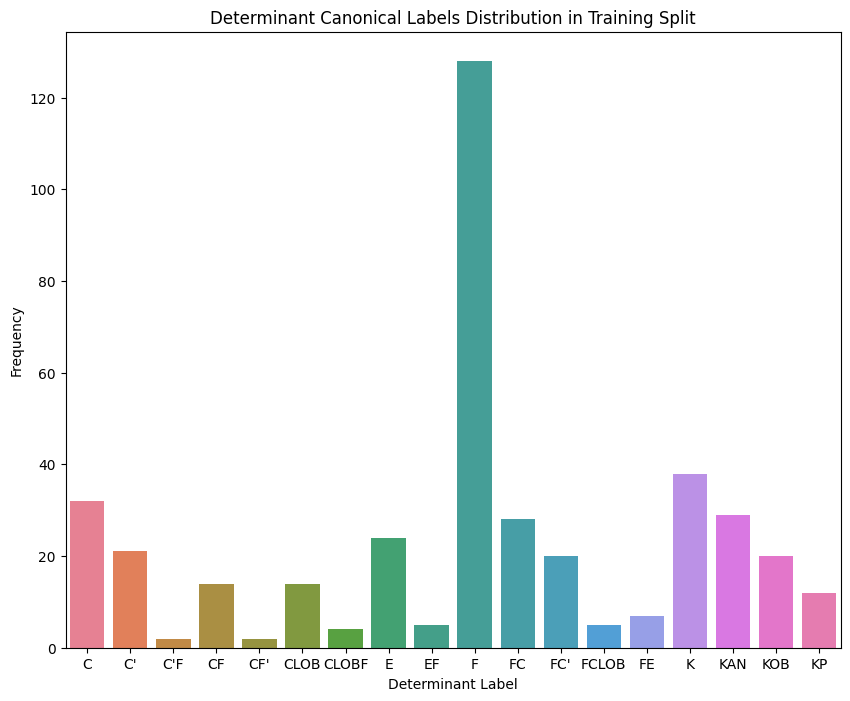

In [21]:
df_ind_dets_distr_train = pd.DataFrame(distribution_class_training, index=[0])
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_ind_dets_distr_train)
plt.title("Determinant Canonical Labels Distribution in Training Split")
ax.set_xlabel("Determinant Label")
ax.set_ylabel("Frequency")
plt.show()

In [23]:
distribution_class_val = count_class(val_df)
distribution_class_val

{'C': 3,
 "C'": 2,
 "C'F": 1,
 'CF': 1,
 "CF'": 'no positive class',
 'CLOB': 1,
 'CLOBF': 'no positive class',
 'E': 3,
 'EF': 1,
 'F': 14,
 'FC': 3,
 "FC'": 2,
 'FCLOB': 'no positive class',
 'FE': 1,
 'K': 4,
 'KAN': 3,
 'KOB': 2,
 'KP': 1}

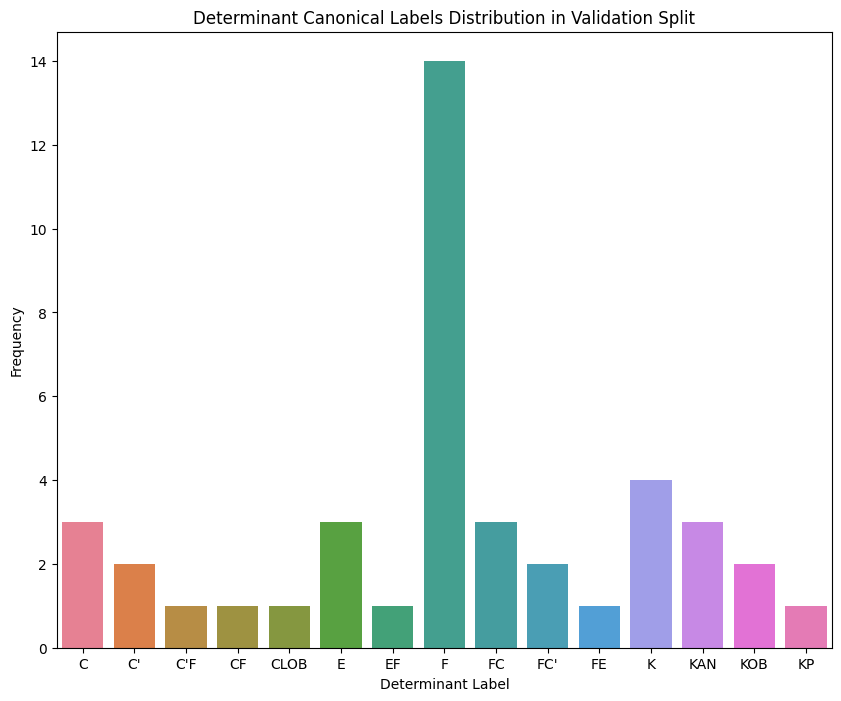

In [24]:
df_distribution_class_val = pd.DataFrame(distribution_class_val, index=[0])
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_val)
plt.title("Determinant Canonical Labels Distribution in Validation Split")
ax.set_xlabel("Determinant Label")
ax.set_ylabel("Frequency")
plt.show()

In [25]:
distribution_class_training = count_class(df_test)
distribution_class_training

{'C': 2,
 "C'": 1,
 "C'F": 'no positive class',
 'CF': 1,
 "CF'": 'no positive class',
 'CLOB': 1,
 'CLOBF': 'no positive class',
 'E': 1,
 'EF': 'no positive class',
 'F': 8,
 'FC': 2,
 "FC'": 1,
 'FCLOB': 'no positive class',
 'FE': 'no positive class',
 'K': 2,
 'KAN': 2,
 'KOB': 1,
 'KP': 1}

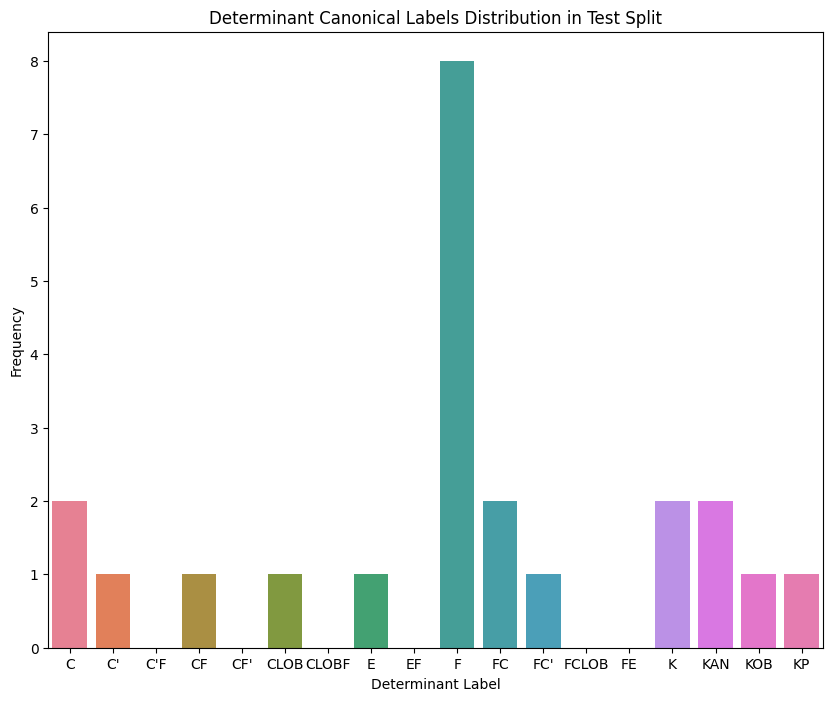

In [28]:
df_distribution_class_training = pd.DataFrame(distribution_class_training, index=[0])
df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
plt.title("Determinant Canonical Labels Distribution in Test Split")
ax.set_xlabel("Determinant Label")
ax.set_ylabel("Frequency")
plt.show()

## Training the models

In [24]:
i = 0
grid_metric_results = []
for hp_dictionary in param_grid_ind_dets:
    print(f"PARAM {i}/{n_grids}")
    print(hp_dictionary)

    # try:

    MAX_LEN, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, EPOCHS, LEARNING_RATE = set_hyperparams(hp_dictionary)

    train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
    valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
    test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

    train_data_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    val_data_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    test_data_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    model = BERTClass()
    model.to(device)
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)


    ckpt_path = "curr_ckpt"
    best_model_path = "best_model.pt"

    trained_model, best_metrics = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path, df_labels)

    metrics, f1, roc_auc, hamming, accuracy, test_loss, metrics_proba, metrics_targets = compute_test_metrics(test_data_loader)

    best_metrics["test"] = {}
    best_metrics["test"]["test_loss"] = test_loss
    best_metrics["test"]["test_f1"] = f1
    best_metrics["test"]["test_roc_auc"] = roc_auc
    best_metrics["test"]["test_hamming"] = hamming
    best_metrics["test"]["test_accuracy"] = accuracy
    best_metrics["test"]["test_proba"] = metrics_proba
    best_metrics["test"]["test_actual_classes"] = metrics_targets

    result = {
          'hyperparameters': hp_dictionary,
          'metrics': best_metrics
      }

    grid_metric_results.append(result)
    i = i + 1

PARAM 0/2
{'max-len': 128, 'learning_rate': 3e-05, 'batch_size': 8, 'num_train_epochs': 40}


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.06481481481481481, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.00      0.00      0.00        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.06481481481481481, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.00      0.00      0.00        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.06481481481481481, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.00      0.00      0.00        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.5119047619047619, 'hamming_loss': 0.06327160493827161, 'f1': 0.046511627906976744, 'accuracy_score': 0.027777777777777776}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       1.00      0.07      0.13        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.591937765205092, 'hamming_loss': 0.05864197530864197, 'f1': 0.2962962962962963, 'accuracy_score': 0.2222222222222222}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.67      0.57      0.62        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
      

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.6038425271098538, 'hamming_loss': 0.05709876543209876, 'f1': 0.32727272727272727, 'accuracy_score': 0.25}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.64      0.67        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB      

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.6124469589816125, 'hamming_loss': 0.06172839506172839, 'f1': 0.33333333333333326, 'accuracy_score': 0.2777777777777778}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.56      0.71      0.63        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.6567656765676567, 'hamming_loss': 0.06172839506172839, 'f1': 0.41176470588235287, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.54      1.00      0.70        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.648986327204149, 'hamming_loss': 0.05555555555555555, 'f1': 0.41935483870967744, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.65      0.93      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
     

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.6805752003771806, 'hamming_loss': 0.05864197530864197, 'f1': 0.4571428571428571, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.54      1.00      0.70        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.6514615747289015, 'hamming_loss': 0.05092592592592592, 'f1': 0.4406779661016949, 'accuracy_score': 0.3333333333333333}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.73      0.79      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.6966053748231965, 'hamming_loss': 0.04938271604938271, 'f1': 0.5151515151515152, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.65      0.93      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.7228901461574728, 'hamming_loss': 0.041666666666666664, 'f1': 0.5846153846153845, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.79      0.79      0.79        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.6863507779349364, 'hamming_loss': 0.047839506172839504, 'f1': 0.5079365079365079, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.6982555398396982, 'hamming_loss': 0.046296296296296294, 'f1': 0.5312499999999999, 'accuracy_score': 0.3333333333333333}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.73      0.79      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.7093352192362093, 'hamming_loss': 0.046296296296296294, 'f1': 0.5454545454545454, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.7195898161244695, 'hamming_loss': 0.047839506172839504, 'f1': 0.5507246376811594, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.60      0.86      0.71        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.7101603017444602, 'hamming_loss': 0.044753086419753084, 'f1': 0.5538461538461539, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.7212399811409712, 'hamming_loss': 0.044753086419753084, 'f1': 0.5671641791044777, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.7212399811409712, 'hamming_loss': 0.044753086419753084, 'f1': 0.5671641791044777, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      1.00      1.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.745049504950495, 'hamming_loss': 0.041666666666666664, 'f1': 0.6086956521739131, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.72      0.93      0.81        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.7323196605374824, 'hamming_loss': 0.044753086419753084, 'f1': 0.5797101449275363, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.733969825553984, 'hamming_loss': 0.041666666666666664, 'f1': 0.5970149253731344, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.7314945780292315, 'hamming_loss': 0.046296296296296294, 'f1': 0.5714285714285714, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.7323196605374824, 'hamming_loss': 0.044753086419753084, 'f1': 0.5797101449275363, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.745049504950495, 'hamming_loss': 0.041666666666666664, 'f1': 0.6086956521739131, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.72      0.93      0.81        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.7442244224422442, 'hamming_loss': 0.043209876543209874, 'f1': 0.6, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      1.00      1.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.67      0.86      0.75        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.7323196605374824, 'hamming_loss': 0.044753086419753084, 'f1': 0.5797101449275363, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.7442244224422442, 'hamming_loss': 0.043209876543209874, 'f1': 0.6, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      1.00      1.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.7331447430457332, 'hamming_loss': 0.043209876543209874, 'f1': 0.588235294117647, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.7323196605374824, 'hamming_loss': 0.044753086419753084, 'f1': 0.5797101449275363, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'roc_auc': 0.7129402657721584, 'hamming_loss': 0.044444444444444446, 'f1': 0.5555555555555555, 'accuracy_score': 0.4}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         2
          C'       0.00      0.00      0.00         1
         C'F       0.00      0.00      0.00         0
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         1
          EF       0.00      0.00      0.00         0
           F       0.80      0.50      0.62         8
          FC       0.00      0.00      0.00         2
         FC'       1.00      1.00      1.00         1
       FCLOB       0.00      0.00      0.00         0
          FE       0.00      0.00      0.00         0
           K       1.00      1.00      1.00         2
         KAN    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.06481481481481481, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.00      0.00      0.00        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.5833333333333334, 'hamming_loss': 0.05401234567901234, 'f1': 0.2857142857142857, 'accuracy_score': 0.19444444444444445}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       1.00      0.50      0.67        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.6473361621876473, 'hamming_loss': 0.05864197530864197, 'f1': 0.40625000000000006, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.59      0.93      0.72        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.6046676096181046, 'hamming_loss': 0.05555555555555555, 'f1': 0.3333333333333333, 'accuracy_score': 0.25}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.75      0.64      0.69        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.6165723715228666, 'hamming_loss': 0.05401234567901234, 'f1': 0.36363636363636365, 'accuracy_score': 0.2777777777777778}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.77      0.71      0.74        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.6982555398396982, 'hamming_loss': 0.046296296296296294, 'f1': 0.5312499999999999, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.76      0.93      0.84        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.6157472890146158, 'hamming_loss': 0.05555555555555555, 'f1': 0.35714285714285715, 'accuracy_score': 0.25}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.64      0.67        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB      

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.6727958510136729, 'hamming_loss': 0.05246913580246913, 'f1': 0.46875000000000006, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.67      0.86      0.75        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.6847006129184346, 'hamming_loss': 0.05092592592592592, 'f1': 0.4923076923076923, 'accuracy_score': 0.3055555555555556}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.64      0.67        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.7093352192362093, 'hamming_loss': 0.046296296296296294, 'f1': 0.5454545454545454, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.6863507779349364, 'hamming_loss': 0.047839506172839504, 'f1': 0.5079365079365079, 'accuracy_score': 0.3333333333333333}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.73      0.57      0.64        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.6514615747289015, 'hamming_loss': 0.05092592592592592, 'f1': 0.4406779661016949, 'accuracy_score': 0.3055555555555556}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         3
          EF       0.00      0.00      0.00         1
           F       0.70      0.50      0.58        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.7076850542197076, 'hamming_loss': 0.04938271604938271, 'f1': 0.5294117647058824, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.67      0.71      0.69        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.6957802923149456, 'hamming_loss': 0.05092592592592592, 'f1': 0.5074626865671642, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.64      0.67        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.7323196605374824, 'hamming_loss': 0.044753086419753084, 'f1': 0.5797101449275363, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.73      0.79      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.7212399811409712, 'hamming_loss': 0.044753086419753084, 'f1': 0.5671641791044777, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.73      0.79      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.6949552098066949, 'hamming_loss': 0.05246913580246913, 'f1': 0.5, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.73      0.79      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
       FCLOB     

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.7187647336162187, 'hamming_loss': 0.04938271604938271, 'f1': 0.5428571428571429, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.7195898161244695, 'hamming_loss': 0.047839506172839504, 'f1': 0.5507246376811594, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.683050447901933, 'hamming_loss': 0.05401234567901234, 'f1': 0.4776119402985074, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.67      0.71      0.69        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.6814002828854314, 'hamming_loss': 0.05709876543209876, 'f1': 0.463768115942029, 'accuracy_score': 0.3611111111111111}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.67      0.71      0.69        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.6838755304101839, 'hamming_loss': 0.05246913580246913, 'f1': 0.4848484848484849, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       0.00      0.00      0.00         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.7076850542197076, 'hamming_loss': 0.04938271604938271, 'f1': 0.5294117647058824, 'accuracy_score': 0.3888888888888889}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.67      0.71      0.69        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.7195898161244695, 'hamming_loss': 0.047839506172839504, 'f1': 0.5507246376811594, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.7076850542197076, 'hamming_loss': 0.04938271604938271, 'f1': 0.5294117647058824, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.7433993399339934, 'hamming_loss': 0.044753086419753084, 'f1': 0.591549295774648, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.7314945780292315, 'hamming_loss': 0.046296296296296294, 'f1': 0.5714285714285714, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.7076850542197076, 'hamming_loss': 0.04938271604938271, 'f1': 0.5294117647058824, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.7068599717114569, 'hamming_loss': 0.05092592592592592, 'f1': 0.5217391304347826, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.7195898161244695, 'hamming_loss': 0.047839506172839504, 'f1': 0.5507246376811594, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.71      0.71        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.7544790193305044, 'hamming_loss': 0.044753086419753084, 'f1': 0.6027397260273972, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.7425742574257426, 'hamming_loss': 0.046296296296296294, 'f1': 0.5833333333333334, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.7195898161244695, 'hamming_loss': 0.047839506172839504, 'f1': 0.5507246376811594, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.71      0.71        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.7187647336162187, 'hamming_loss': 0.04938271604938271, 'f1': 0.5428571428571429, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.73      0.79      0.76        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.7433993399339934, 'hamming_loss': 0.044753086419753084, 'f1': 0.591549295774648, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.7425742574257426, 'hamming_loss': 0.046296296296296294, 'f1': 0.5833333333333334, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.7544790193305044, 'hamming_loss': 0.044753086419753084, 'f1': 0.6027397260273972, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.7306694955209807, 'hamming_loss': 0.047839506172839504, 'f1': 0.5633802816901408, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.69      0.79      0.73        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.7417491749174917, 'hamming_loss': 0.047839506172839504, 'f1': 0.5753424657534247, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
          C'       1.00      0.50      0.67         2
         C'F       0.00      0.00      0.00         1
          CF       1.00      1.00      1.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       1.00      0.33      0.50         3
          EF       0.00      0.00      0.00         1
           F       0.71      0.86      0.77        14
          FC       0.00      0.00      0.00         3
         FC'       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'roc_auc': 0.6852664172364855, 'hamming_loss': 0.058333333333333334, 'f1': 0.46153846153846156, 'accuracy_score': 0.35}
              precision    recall  f1-score   support

           C       1.00      0.50      0.67         2
          C'       0.00      0.00      0.00         1
         C'F       0.00      0.00      0.00         0
          CF       0.00      0.00      0.00         1
         CF'       0.00      0.00      0.00         0
        CLOB       0.00      0.00      0.00         1
       CLOBF       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         1
          EF       0.00      0.00      0.00         0
           F       0.60      0.38      0.46         8
          FC       0.00      0.00      0.00         2
         FC'       0.25      1.00      0.40         1
       FCLOB       0.00      0.00      0.00         0
          FE       0.00      0.00      0.00         0
           K       1.00      1.00      1.00         2
         KAN  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [25]:
with open("metrics_ind_dets_final.json", "w") as f:
    json.dump(grid_metric_results, f)

# Individual Contents

In [85]:
param_grid_ind_conts = [
                        {
                        'max-len' : 128,
                        'learning_rate': 3e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                },
                        {
                        'max-len' : 128,
                        'learning_rate': 5e-5,
                        'batch_size': 12,
                        'num_train_epochs': 40
                                                }]
n_grids = len(param_grid_ind_conts)

In [29]:
df_name = dfs[1]
data_model = df_name.split("_")
data_model = "_".join(data_model[1:3]) #getting the name to name the different dictionaries
df = pd.read_csv(df_name)

test_proportion = 0.05
train_size = 0.9

train_df, val_df, df_test, df_labels  = pre_process_data(df, test_proportion, train_size)

<class 'pandas.core.frame.DataFrame'>
Index: 380 entries, 266 to 102
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   (A)     380 non-null    float32
 1   (AD)    380 non-null    float32
 2   (H)     380 non-null    float32
 3   (HD)    380 non-null    float32
 4   A       380 non-null    float32
 5   ABS     380 non-null    float32
 6   AD      380 non-null    float32
 7   ALIM    380 non-null    float32
 8   ANAT    380 non-null    float32
 9   ARCH    380 non-null    float32
 10  ART     380 non-null    float32
 11  BOT     380 non-null    float32
 12  ELEM    380 non-null    float32
 13  FRAG    380 non-null    float32
 14  GÉO     380 non-null    float32
 15  H       380 non-null    float32
 16  HD      380 non-null    float32
 17  MQ      380 non-null    float32
 18  NAT     380 non-null    float32
 19  OBJ     380 non-null    float32
 20  PAYS    380 non-null    float32
 21  RADIO   380 non-null    float32
 22  SC   

## Distribution of the classes in train, validate, test dfs

In [30]:
distribution_class_training = count_class(train_df)
distribution_class_training

{'(A)': 10,
 '(AD)': 5,
 '(H)': 15,
 '(HD)': 6,
 'A': 95,
 'ABS': 15,
 'AD': 40,
 'ALIM': 5,
 'ANAT': 18,
 'ARCH': 7,
 'ART': 4,
 'BOT': 16,
 'ELEM': 20,
 'FRAG': 20,
 'GÉO': 2,
 'H': 31,
 'HD': 40,
 'MQ': 4,
 'NAT': 7,
 'OBJ': 36,
 'PAYS': 15,
 'RADIO': 1,
 'SC': 1,
 'SCÈNE': 3,
 'SEX': 6,
 'SG': 10,
 'VÊT': 11}

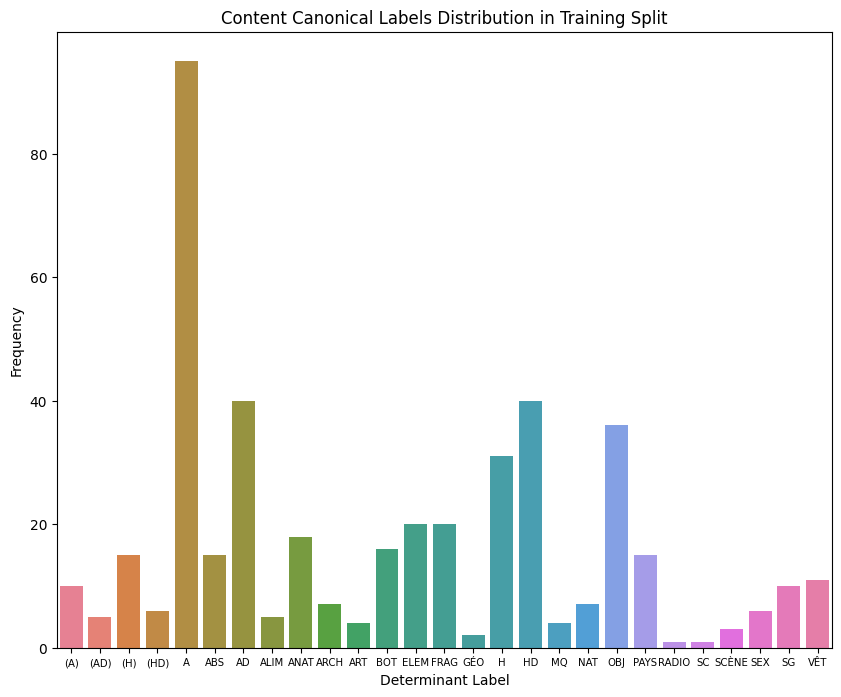

In [35]:
df_distribution_class_training = pd.DataFrame(distribution_class_training, index=[0])
df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
plt.xticks(fontsize=7.25)
plt.title("Content Canonical Labels Distribution in Training Split")
ax.set_xlabel("Content Label")
ax.set_ylabel("Frequency")
plt.show()

In [36]:
distribution_class_validation = count_class(val_df)
distribution_class_validation

{'(A)': 1,
 '(AD)': 'no positive class',
 '(H)': 2,
 '(HD)': 1,
 'A': 10,
 'ABS': 2,
 'AD': 4,
 'ALIM': 1,
 'ANAT': 2,
 'ARCH': 1,
 'ART': 'no positive class',
 'BOT': 2,
 'ELEM': 2,
 'FRAG': 2,
 'GÉO': 'no positive class',
 'H': 3,
 'HD': 4,
 'MQ': 'no positive class',
 'NAT': 1,
 'OBJ': 4,
 'PAYS': 2,
 'RADIO': 'no positive class',
 'SC': 'no positive class',
 'SCÈNE': 'no positive class',
 'SEX': 1,
 'SG': 1,
 'VÊT': 1}

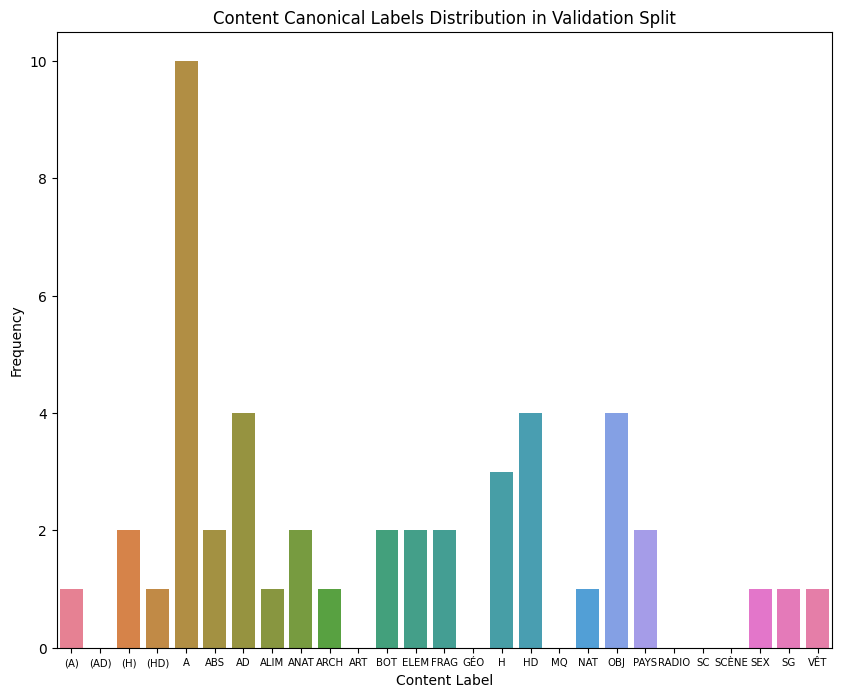

In [37]:
df_distribution_class_training = pd.DataFrame(distribution_class_validation, index=[0])
df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
plt.xticks(fontsize=7.25)
plt.title("Content Canonical Labels Distribution in Validation Split")
ax.set_xlabel("Content Label")
ax.set_ylabel("Frequency")
plt.show()

In [38]:
distribution_class_test = count_class(df_test)
distribution_class_test

{'(A)': 1,
 '(AD)': 'no positive class',
 '(H)': 1,
 '(HD)': 'no positive class',
 'A': 6,
 'ABS': 1,
 'AD': 2,
 'ALIM': 'no positive class',
 'ANAT': 1,
 'ARCH': 'no positive class',
 'ART': 'no positive class',
 'BOT': 1,
 'ELEM': 1,
 'FRAG': 1,
 'GÉO': 'no positive class',
 'H': 2,
 'HD': 2,
 'MQ': 'no positive class',
 'NAT': 'no positive class',
 'OBJ': 2,
 'PAYS': 1,
 'RADIO': 'no positive class',
 'SC': 'no positive class',
 'SCÈNE': 'no positive class',
 'SEX': 'no positive class',
 'SG': 1,
 'VÊT': 1}

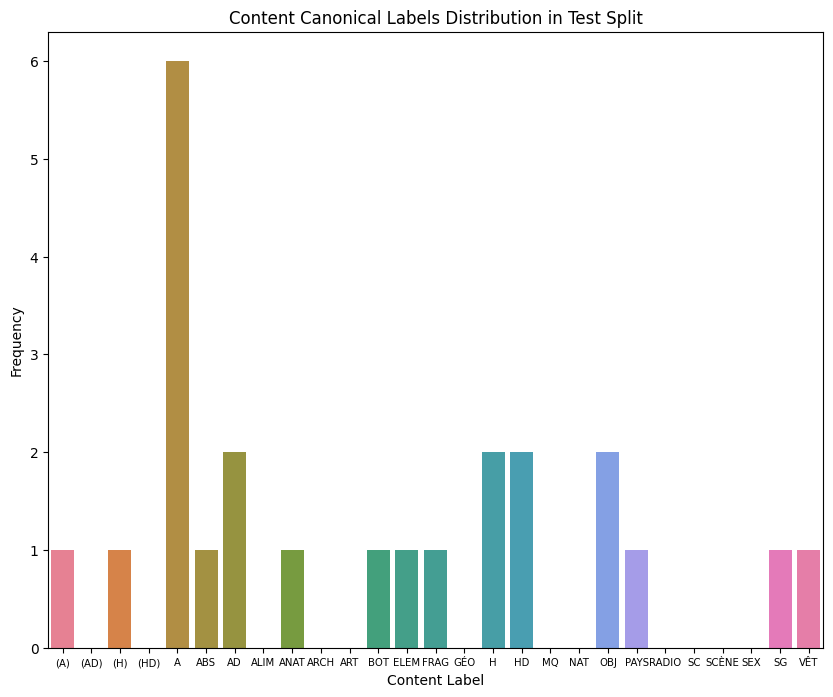

In [39]:
df_distribution_class_training = pd.DataFrame(distribution_class_test, index=[0])
df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
plt.xticks(fontsize=7.25)
plt.title("Content Canonical Labels Distribution in Test Split")
ax.set_xlabel("Content Label")
ax.set_ylabel("Frequency")
plt.show()

# Training the models

In [28]:
i = 0
grid_metric_results = []
for hp_dictionary in param_grid_ind_conts:
    print(f"PARAM {i}/{n_grids}")
    print(hp_dictionary)

    # try:

    MAX_LEN, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, EPOCHS, LEARNING_RATE = set_hyperparams(hp_dictionary)

    train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
    valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
    test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

    train_data_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    val_data_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    test_data_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    model = BERTClass()
    model.to(device)
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)


    ckpt_path = "curr_ckpt"
    best_model_path = "best_model.pt"

    trained_model, best_metrics = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path, df_labels)

    metrics, f1, roc_auc, hamming, accuracy, test_loss, metrics_proba, metrics_targets = compute_test_metrics(test_data_loader)

    best_metrics["test"] = {}
    best_metrics["test"]["test_loss"] = test_loss
    best_metrics["test"]["test_f1"] = f1
    best_metrics["test"]["test_roc_auc"] = roc_auc
    best_metrics["test"]["test_hamming"] = hamming
    best_metrics["test"]["test_accuracy"] = accuracy
    best_metrics["test"]["test_proba"] = metrics_proba
    best_metrics["test"]["test_actual_classes"] = metrics_targets

    result = {
          'hyperparameters': hp_dictionary,
          'metrics': best_metrics
      }

    grid_metric_results.append(result)
    i = i + 1

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


PARAM 0/2
{'max-len': 128, 'learning_rate': 3e-05, 'batch_size': 8, 'num_train_epochs': 40}
############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.563358089120835, 'hamming_loss': 0.037940379403794036, 'f1': 0.2222222222222222, 'accuracy_score': 0.12195121951219512}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.86      0.60      0.71        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.5846346848655157, 'hamming_loss': 0.036133694670280034, 'f1': 0.2857142857142857, 'accuracy_score': 0.14634146341463414}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.563358089120835, 'hamming_loss': 0.037940379403794036, 'f1': 0.2222222222222222, 'accuracy_score': 0.0975609756097561}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.86      0.60      0.71        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
     

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.5952729827378562, 'hamming_loss': 0.03523035230352303, 'f1': 0.3157894736842105, 'accuracy_score': 0.17073170731707318}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.90      0.90      0.90        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.6054395824969893, 'hamming_loss': 0.03523035230352303, 'f1': 0.3389830508474576, 'accuracy_score': 0.1951219512195122}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
     

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.6059112806101967, 'hamming_loss': 0.03432700993676603, 'f1': 0.3448275862068965, 'accuracy_score': 0.1951219512195122}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.91      1.00      0.95        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.6257727820152549, 'hamming_loss': 0.03523035230352303, 'f1': 0.380952380952381, 'accuracy_score': 0.24390243902439024}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.00      0.00      0.00         2
          AD       0.33      0.25      0.29         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.6267161782416699, 'hamming_loss': 0.03342366757000903, 'f1': 0.3934426229508196, 'accuracy_score': 0.24390243902439024}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.91      1.00      0.95        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.6567442794058611, 'hamming_loss': 0.03432700993676603, 'f1': 0.4411764705882353, 'accuracy_score': 0.24390243902439024}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.50      1.00      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.6683259735046166, 'hamming_loss': 0.031616982836495035, 'f1': 0.47761194029850745, 'accuracy_score': 0.3170731707317073}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.50      0.50      0.50         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.6784925732637495, 'hamming_loss': 0.031616982836495035, 'f1': 0.4927536231884059, 'accuracy_score': 0.3170731707317073}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.40      0.50      0.44         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.6867723805700522, 'hamming_loss': 0.03523035230352303, 'f1': 0.48, 'accuracy_score': 0.2926829268292683}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.00      0.00      0.00         2
          AD       0.33      0.50      0.40         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.6775491770373343, 'hamming_loss': 0.03342366757000903, 'f1': 0.4788732394366197, 'accuracy_score': 0.3170731707317073}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.43      0.75      0.55         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.7409072661581694, 'hamming_loss': 0.028906955736224028, 'f1': 0.5897435897435898, 'accuracy_score': 0.3902439024390244}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       0.00      0.00      0.00         2
          AD       0.50      1.00      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.7089923725411481, 'hamming_loss': 0.031616982836495035, 'f1': 0.5333333333333333, 'accuracy_score': 0.34146341463414637}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       0.00      0.00      0.00         2
          AD       0.50      0.75      0.60         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.7404355680449618, 'hamming_loss': 0.02981029810298103, 'f1': 0.5822784810126582, 'accuracy_score': 0.4146341463414634}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.40      0.50      0.44         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.7385487755921316, 'hamming_loss': 0.03342366757000903, 'f1': 0.5542168674698795, 'accuracy_score': 0.36585365853658536}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.91      1.00      0.95        10
         ABS       1.00      0.50      0.67         2
          AD       0.43      0.75      0.55         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.7288538739462063, 'hamming_loss': 0.032520325203252036, 'f1': 0.55, 'accuracy_score': 0.3902439024390244}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       1.00      0.50      0.67         2
          AD       0.43      0.75      0.55         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
        ELEM   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.7520172621437172, 'hamming_loss': 0.02710027100271003, 'f1': 0.6153846153846153, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.50      0.50      0.50         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.7602970694500201, 'hamming_loss': 0.03071364046973803, 'f1': 0.5952380952380952, 'accuracy_score': 0.4146341463414634}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.43      0.75      0.55         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.7806302689682858, 'hamming_loss': 0.03071364046973803, 'f1': 0.6136363636363638, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.50      0.50      0.50         2
          AD       0.50      1.00      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.7307406663990366, 'hamming_loss': 0.028906955736224028, 'f1': 0.5789473684210527, 'accuracy_score': 0.4146341463414634}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       1.00      0.50      0.67         2
          AD       0.60      0.75      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.7607687675632275, 'hamming_loss': 0.02981029810298103, 'f1': 0.6024096385542169, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       1.00      0.50      0.67         2
          AD       0.50      1.00      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.7820453633079084, 'hamming_loss': 0.028003613369467027, 'f1': 0.6352941176470589, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.50      1.00      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.770463669209153, 'hamming_loss': 0.03071364046973803, 'f1': 0.6046511627906976, 'accuracy_score': 0.43902439024390244}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.50      1.00      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.7922119630670413, 'hamming_loss': 0.028003613369467027, 'f1': 0.6436781609195402, 'accuracy_score': 0.5121951219512195}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       1.00      0.50      0.67         2
          AD       0.50      1.00      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.7806302689682858, 'hamming_loss': 0.03071364046973803, 'f1': 0.6136363636363638, 'accuracy_score': 0.5121951219512195}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.50      0.50      0.50         2
          AD       0.50      1.00      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.771407065435568, 'hamming_loss': 0.028906955736224028, 'f1': 0.6190476190476191, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.67      1.00      0.80         2
          AD       0.50      1.00      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.770463669209153, 'hamming_loss': 0.03071364046973803, 'f1': 0.6046511627906976, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       0.67      1.00      0.80         2
          AD       0.50      1.00      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.770463669209153, 'hamming_loss': 0.03071364046973803, 'f1': 0.6046511627906976, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.33      0.50      0.40         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.7820453633079084, 'hamming_loss': 0.028003613369467027, 'f1': 0.6352941176470589, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.43      0.75      0.55         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.781573665194701, 'hamming_loss': 0.028906955736224028, 'f1': 0.627906976744186, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.50      1.00      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.8125451625853071, 'hamming_loss': 0.028003613369467027, 'f1': 0.6593406593406593, 'accuracy_score': 0.5365853658536586}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       0.67      1.00      0.80         2
          AD       0.50      1.00      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.7912685668406263, 'hamming_loss': 0.02981029810298103, 'f1': 0.6292134831460674, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      0.50      0.67         2
          AD       0.50      1.00      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.7811019670814934, 'hamming_loss': 0.02981029810298103, 'f1': 0.6206896551724138, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.67      1.00      0.80         2
          AD       0.38      0.75      0.50         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.8130168606985146, 'hamming_loss': 0.02710027100271003, 'f1': 0.6666666666666666, 'accuracy_score': 0.5365853658536586}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.83      1.00      0.91        10
         ABS       1.00      1.00      1.00         2
          AD       0.50      1.00      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'roc_auc': 0.8708123953098827, 'hamming_loss': 0.017713365539452495, 'f1': 0.7659574468085107, 'accuracy_score': 0.6521739130434783}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       1.00      1.00      1.00         1
        (HD)       0.00      0.00      0.00         0
           A       1.00      1.00      1.00         6
         ABS       1.00      1.00      1.00         1
          AD       0.25      0.50      0.33         2
        ALIM       0.00      0.00      0.00         0
        ANAT       0.00      0.00      0.00         1
        ARCH       0.00      0.00      0.00         0
         ART       0.00      0.00      0.00         0
         BOT       1.00      1.00      1.00         1
        ELEM       0.33      1.00      0.50         1
        FRAG       0.00      0.00      0.00         1
         GÉO       0.00      0.00      0.00         0
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.04245709123757904, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.00      0.00      0.00        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
        ELEM       0.00      0.00      0.00       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.5314431955038137, 'hamming_loss': 0.04065040650406504, 'f1': 0.11764705882352941, 'accuracy_score': 0.07317073170731707}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.75      0.30      0.43        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.5836912886391007, 'hamming_loss': 0.037940379403794036, 'f1': 0.27586206896551724, 'accuracy_score': 0.17073170731707318}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.73      0.80      0.76        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.5952729827378562, 'hamming_loss': 0.03523035230352303, 'f1': 0.3157894736842105, 'accuracy_score': 0.1951219512195122}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.90      0.90      0.90        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
     

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.563358089120835, 'hamming_loss': 0.037940379403794036, 'f1': 0.2222222222222222, 'accuracy_score': 0.12195121951219512}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.86      0.60      0.71        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.5948012846246487, 'hamming_loss': 0.036133694670280034, 'f1': 0.31034482758620685, 'accuracy_score': 0.1951219512195122}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.00      0.00      0.00         2
          AD       0.00      0.00      0.00         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.6267161782416699, 'hamming_loss': 0.03342366757000903, 'f1': 0.3934426229508196, 'accuracy_score': 0.24390243902439024}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.67      0.50      0.57         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.6364110798875954, 'hamming_loss': 0.03432700993676603, 'f1': 0.40624999999999994, 'accuracy_score': 0.24390243902439024}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.90      0.90      0.90        10
         ABS       0.00      0.00      0.00         2
          AD       1.00      0.25      0.40         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.6794359694901645, 'hamming_loss': 0.02981029810298103, 'f1': 0.5074626865671642, 'accuracy_score': 0.36585365853658536}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.00      0.00      0.00         2
          AD       0.67      0.50      0.57         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.6891308711360898, 'hamming_loss': 0.03071364046973803, 'f1': 0.5142857142857143, 'accuracy_score': 0.36585365853658536}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.75      0.75      0.75         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.678020875150542, 'hamming_loss': 0.032520325203252036, 'f1': 0.4857142857142858, 'accuracy_score': 0.34146341463414637}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.78      0.70      0.74        10
         ABS       0.00      0.00      0.00         2
          AD       0.60      0.75      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.00      0.00      0.00         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.7205740666399035, 'hamming_loss': 0.028906955736224028, 'f1': 0.5675675675675675, 'accuracy_score': 0.3902439024390244}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       1.00      0.75      0.86         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.67      1.00      0.80         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.720102368526696, 'hamming_loss': 0.02981029810298103, 'f1': 0.56, 'accuracy_score': 0.43902439024390244}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.00      0.00      0.00         2
          AD       0.75      0.75      0.75         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
        ELEM    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.6992974708952228, 'hamming_loss': 0.03071364046973803, 'f1': 0.5277777777777778, 'accuracy_score': 0.3902439024390244}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.67      0.50      0.57         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.7177438779606583, 'hamming_loss': 0.03432700993676603, 'f1': 0.5249999999999999, 'accuracy_score': 0.36585365853658536}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.40      1.00      0.57         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.7297972701726214, 'hamming_loss': 0.03071364046973803, 'f1': 0.5641025641025641, 'accuracy_score': 0.4146341463414634}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.90      0.90      0.90        10
         ABS       0.00      0.00      0.00         2
          AD       0.57      1.00      0.73         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.7089923725411481, 'hamming_loss': 0.031616982836495035, 'f1': 0.5333333333333333, 'accuracy_score': 0.36585365853658536}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.67      1.00      0.80         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.7307406663990366, 'hamming_loss': 0.028906955736224028, 'f1': 0.5789473684210527, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.80      1.00      0.89         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.7839321557607386, 'hamming_loss': 0.024390243902439025, 'f1': 0.6666666666666666, 'accuracy_score': 0.5365853658536586}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       1.00      0.50      0.67         2
          AD       1.00      1.00      1.00         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.50      1.00      0.67         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.7617121637896427, 'hamming_loss': 0.028003613369467027, 'f1': 0.617283950617284, 'accuracy_score': 0.43902439024390244}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.67      1.00      0.80         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.67      1.00      0.80         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.7515455640305098, 'hamming_loss': 0.028003613369467027, 'f1': 0.6075949367088608, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.89      0.80      0.84        10
         ABS       0.00      0.00      0.00         2
          AD       0.60      0.75      0.67         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.7413789642713768, 'hamming_loss': 0.028003613369467027, 'f1': 0.5974025974025974, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       0.00      0.00      0.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       1.00      0.50      0.67         2
          AD       1.00      0.75      0.86         4
        ALIM       0.00      0.00      0.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.7931553592934564, 'hamming_loss': 0.026196928635953028, 'f1': 0.6588235294117647, 'accuracy_score': 0.5365853658536586}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       0.00      0.00      0.00         2
          AD       0.75      0.75      0.75         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.50      0.50      0.50         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.781573665194701, 'hamming_loss': 0.028906955736224028, 'f1': 0.627906976744186, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.78      0.70      0.74        10
         ABS       1.00      1.00      1.00         2
          AD       0.50      0.75      0.60         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.50      1.00      0.67         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      1.00      1.00         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.7621838619028503, 'hamming_loss': 0.02710027100271003, 'f1': 0.625, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.67      1.00      0.80         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      1.00      1.00         2
        ELEM   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.750130469690887, 'hamming_loss': 0.03071364046973803, 'f1': 0.5853658536585366, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.60      0.75      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.33      0.50      0.40         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.7834604576475311, 'hamming_loss': 0.025293586269196026, 'f1': 0.6585365853658536, 'accuracy_score': 0.5365853658536586}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       1.00      0.50      0.67         2
          AD       1.00      0.75      0.86         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.67      1.00      0.80         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.7940987555198715, 'hamming_loss': 0.024390243902439025, 'f1': 0.674698795180723, 'accuracy_score': 0.5609756097560976}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       1.00      1.00      1.00         2
          AD       1.00      0.75      0.86         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.67      1.00      0.80         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.7723504616619832, 'hamming_loss': 0.02710027100271003, 'f1': 0.6341463414634146, 'accuracy_score': 0.5121951219512195}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.82      0.90      0.86        10
         ABS       0.00      0.00      0.00         2
          AD       0.75      0.75      0.75         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.50      0.50      0.50         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.7510738659173022, 'hamming_loss': 0.028906955736224028, 'f1': 0.5999999999999999, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.75      0.75      0.75         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.67      1.00      0.80         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.50      0.50      0.50         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.771407065435568, 'hamming_loss': 0.028906955736224028, 'f1': 0.6190476190476191, 'accuracy_score': 0.4878048780487805}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       1.00      0.50      0.67         2
          AD       0.60      0.75      0.67         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.7931553592934564, 'hamming_loss': 0.026196928635953028, 'f1': 0.6588235294117647, 'accuracy_score': 0.5365853658536586}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.88      0.70      0.78        10
         ABS       0.00      0.00      0.00         2
          AD       0.75      0.75      0.75         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.67      1.00      0.80         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       0.50      0.50      0.50         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.782517061421116, 'hamming_loss': 0.02710027100271003, 'f1': 0.6428571428571429, 'accuracy_score': 0.5121951219512195}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       1.00      0.50      0.67         2
          AD       0.75      0.75      0.75         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.50      1.00      0.67         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.782517061421116, 'hamming_loss': 0.02710027100271003, 'f1': 0.6428571428571429, 'accuracy_score': 0.5121951219512195}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.78      0.70      0.74        10
         ABS       1.00      0.50      0.67         2
          AD       0.75      0.75      0.75         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.50      1.00      0.67         2
        ARCH       1.00      1.00      1.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.7699919710959455, 'hamming_loss': 0.031616982836495035, 'f1': 0.5977011494252874, 'accuracy_score': 0.4634146341463415}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       0.00      0.00      0.00         2
        (HD)       0.00      0.00      0.00         1
           A       0.80      0.80      0.80        10
         ABS       1.00      0.50      0.67         2
          AD       0.44      1.00      0.62         4
        ALIM       1.00      1.00      1.00         1
        ANAT       0.00      0.00      0.00         2
        ARCH       0.00      0.00      0.00         1
         ART       0.00      0.00      0.00         0
         BOT       1.00      0.50      0.67         2
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'roc_auc': 0.8266331658291457, 'hamming_loss': 0.02576489533011272, 'f1': 0.6666666666666666, 'accuracy_score': 0.5652173913043478}
              precision    recall  f1-score   support

         (A)       1.00      1.00      1.00         1
        (AD)       0.00      0.00      0.00         0
         (H)       1.00      1.00      1.00         1
        (HD)       0.00      0.00      0.00         0
           A       1.00      1.00      1.00         6
         ABS       0.00      0.00      0.00         1
          AD       0.33      0.50      0.40         2
        ALIM       0.00      0.00      0.00         0
        ANAT       0.00      0.00      0.00         1
        ARCH       0.00      0.00      0.00         0
         ART       0.00      0.00      0.00         0
         BOT       0.33      1.00      0.50         1
        ELEM       0.33      1.00      0.50         1
        FRAG       0.00      0.00      0.00         1
         GÉO       0.00      0.00      0.00         0
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [29]:
with open("metrics_ind_conts_final.json", "w") as f:
    json.dump(grid_metric_results, f)

# Macro Contents

In [30]:
param_grid_macro_cont = [
                        {
                        'max-len' : 128,
                        'learning_rate': 3e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                },
                        {
                        'max-len' : 128,
                        'learning_rate': 5e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                },
                         {
                        'max-len' : 128,
                        'learning_rate': 2e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                },
                        {
                        'max-len' : 128,
                        'learning_rate': 5e-5,
                        'batch_size': 12,
                        'num_train_epochs': 40
                                                }]
n_grids = len(param_grid_macro_cont)

In [40]:
df_name = dfs[2]
data_model = df_name.split("_")
data_model = "_".join(data_model[1:3]) #getting the name to name the different dictionaries
df = pd.read_csv(df_name)

test_proportion = 0.05
train_size = 0.9

train_df, val_df, df_test, df_labels  = pre_process_data(df, test_proportion, train_size)

<class 'pandas.core.frame.DataFrame'>
Index: 380 entries, 266 to 102
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   animal_sum    380 non-null    float32
 1   human_sum     380 non-null    float32
 2   abs_sum       380 non-null    float32
 3   food_sum      380 non-null    float32
 4   art_arch_sum  380 non-null    float32
 5   nature_sum    380 non-null    float32
 6   fragment_sum  380 non-null    float32
 7   geo_sum       380 non-null    float32
 8   object_sum    380 non-null    float32
 9   science_sum   380 non-null    float32
 10  graphic_sum   380 non-null    float32
dtypes: float32(11)
memory usage: 19.3 KB
None
['animal_sum', 'human_sum', 'abs_sum', 'food_sum', 'art_arch_sum', 'nature_sum', 'fragment_sum', 'geo_sum', 'object_sum', 'science_sum', 'graphic_sum']
Total amount of data: 380
Number of rows used to TRAIN: 323
Number of rows used to VALIDATE: 36
Number of rows used to TEST: 21


## Distribution of the classes in train, validate, test dfs


In [41]:
distribution_class_training = count_class(train_df)
distribution_class_training


{'animal_sum': 153,
 'human_sum': 85,
 'abs_sum': 15,
 'food_sum': 5,
 'art_arch_sum': 12,
 'nature_sum': 41,
 'fragment_sum': 20,
 'geo_sum': 2,
 'object_sum': 49,
 'science_sum': 2,
 'graphic_sum': 16}

In [46]:
df_distribution_class_training.columns

Index(['animal_sum', 'human_sum', 'abs_sum', 'food_sum', 'art_arch_sum',
       'nature_sum', 'fragment_sum', 'geo_sum', 'object_sum', 'science_sum',
       'graphic_sum'],
      dtype='object')

In [ ]:
["Animal", "Human", "Abs", "Food", "Art and Architecture", "Nature", "Fragment", "Geo", "Object", "Science", "Graphic"]

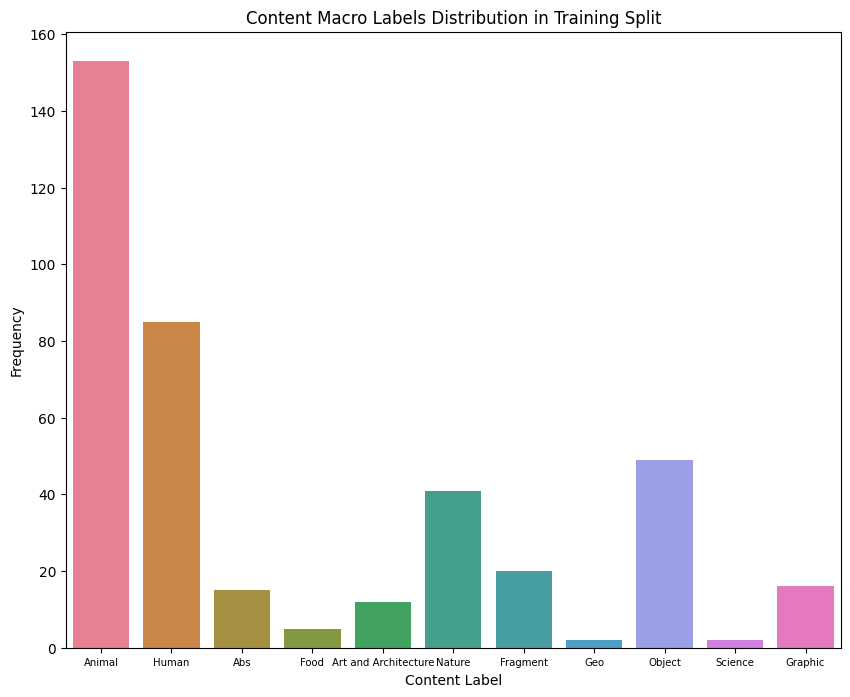

In [50]:
df_distribution_class_training = pd.DataFrame(distribution_class_training, index=[0])

df_distribution_class_training.columns = ["Animal", "Human", "Abs", "Food", "Art and Architecture", "Nature", "Fragment", "Geo", "Object", "Science", "Graphic"]

df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
plt.xticks(fontsize=7.25)
plt.title("Content Macro Labels Distribution in Training Split")
ax.set_xlabel("Content Label")
ax.set_ylabel("Frequency")
plt.show()

In [51]:
distribution_class_val = count_class(val_df)
distribution_class_val

{'animal_sum': 17,
 'human_sum': 9,
 'abs_sum': 2,
 'food_sum': 1,
 'art_arch_sum': 1,
 'nature_sum': 4,
 'fragment_sum': 2,
 'geo_sum': 'no positive class',
 'object_sum': 5,
 'science_sum': 'no positive class',
 'graphic_sum': 2}

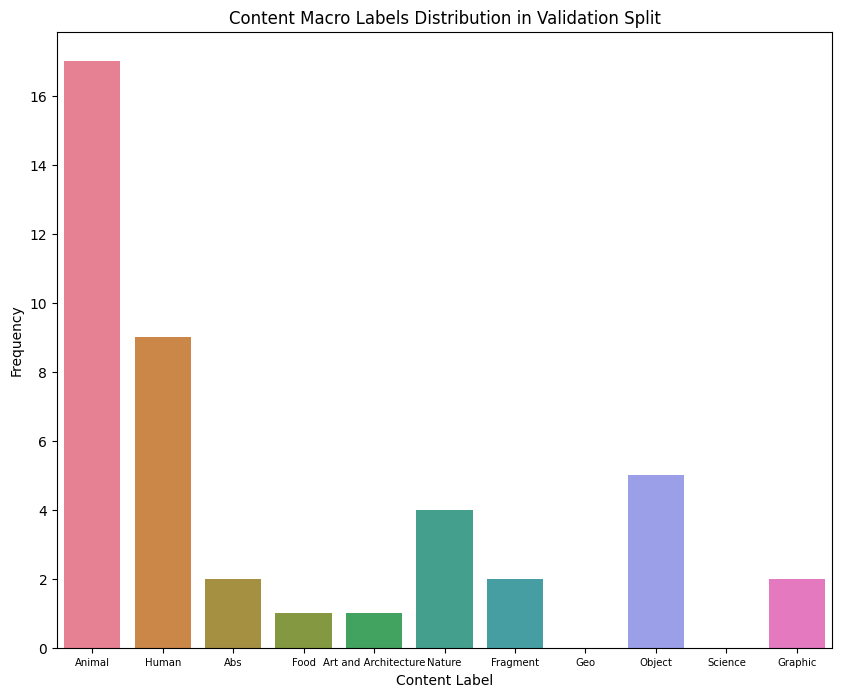

In [53]:
df_distribution_class_training = pd.DataFrame(distribution_class_val, index=[0])

df_distribution_class_training.columns = ["Animal", "Human", "Abs", "Food", "Art and Architecture", "Nature", "Fragment", "Geo", "Object", "Science", "Graphic"]

df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
plt.xticks(fontsize=7.25)
plt.title("Content Macro Labels Distribution in Validation Split")
ax.set_xlabel("Content Label")
ax.set_ylabel("Frequency")
plt.show()

In [54]:
distribution_class_test = count_class(df_test)
distribution_class_test

{'animal_sum': 9,
 'human_sum': 5,
 'abs_sum': 1,
 'food_sum': 'no positive class',
 'art_arch_sum': 1,
 'nature_sum': 2,
 'fragment_sum': 1,
 'geo_sum': 'no positive class',
 'object_sum': 3,
 'science_sum': 'no positive class',
 'graphic_sum': 1}

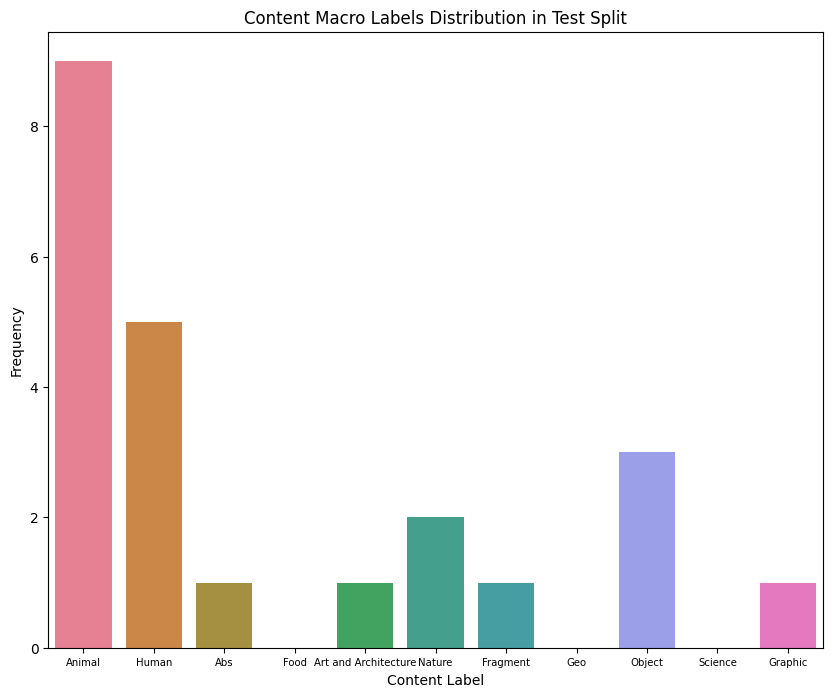

In [55]:
df_distribution_class_training = pd.DataFrame(distribution_class_test, index=[0])

df_distribution_class_training.columns = ["Animal", "Human", "Abs", "Food", "Art and Architecture", "Nature", "Fragment", "Geo", "Object", "Science", "Graphic"]

df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
plt.xticks(fontsize=7.25)
plt.title("Content Macro Labels Distribution in Test Split")
ax.set_xlabel("Content Label")
ax.set_ylabel("Frequency")
plt.show()

## Training the models


In [32]:
i = 0
grid_metric_results = []
for hp_dictionary in param_grid_macro_cont:
    print(f"PARAM {i}/{n_grids}")
    print(hp_dictionary)

    # try:

    MAX_LEN, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, EPOCHS, LEARNING_RATE = set_hyperparams(hp_dictionary)

    train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
    valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
    test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

    train_data_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    val_data_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    test_data_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    model = BERTClass()
    model.to(device)
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)


    ckpt_path = "curr_ckpt"
    best_model_path = "best_model.pt"

    trained_model, best_metrics = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path, df_labels)

    metrics, f1, roc_auc, hamming, accuracy, test_loss, metrics_proba, metrics_targets = compute_test_metrics(test_data_loader)

    best_metrics["test"] = {}
    best_metrics["test"]["test_loss"] = test_loss
    best_metrics["test"]["test_f1"] = f1
    best_metrics["test"]["test_roc_auc"] = roc_auc
    best_metrics["test"]["test_hamming"] = hamming
    best_metrics["test"]["test_accuracy"] = accuracy
    best_metrics["test"]["test_proba"] = metrics_proba
    best_metrics["test"]["test_actual_classes"] = metrics_targets

    result = {
          'hyperparameters': hp_dictionary,
          'metrics': best_metrics
      }

    grid_metric_results.append(result)
    i = i + 1

PARAM 0/4
{'max-len': 128, 'learning_rate': 3e-05, 'batch_size': 8, 'num_train_epochs': 40}


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.10858585858585859, 'f1': 0.0, 'accuracy_score': 0.0}
              precision    recall  f1-score   support

  animal_sum       0.00      0.00      0.00        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00      

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.5936161802490282, 'hamming_loss': 0.12373737373737374, 'f1': 0.2898550724637681, 'accuracy_score': 0.2222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.38      0.59      0.47        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.38      0.23      0.29        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.6500428223203111, 'hamming_loss': 0.09595959595959595, 'f1': 0.42424242424242425, 'accuracy_score': 0.3333333333333333}
              precision    recall  f1-score   support

  animal_sum       0.61      0.82      0.70        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.61      0.33      0.42        43
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.7575268463008104, 'hamming_loss': 0.06818181818181818, 'f1': 0.6301369863013698, 'accuracy_score': 0.5}
              precision    recall  f1-score   support

  animal_sum       0.77      1.00      0.87        17
   human_sum       0.75      0.67      0.71         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.77      0.53      0.63        43
   macro avg       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.7444825087291653, 'hamming_loss': 0.07323232323232323, 'f1': 0.6027397260273971, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

  animal_sum       0.74      1.00      0.85        17
   human_sum       0.71      0.56      0.63         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.73      0.51      0.60        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.7705711838724555, 'hamming_loss': 0.06313131313131314, 'f1': 0.6575342465753425, 'accuracy_score': 0.5555555555555556}
              precision    recall  f1-score   support

  animal_sum       0.74      1.00      0.85        17
   human_sum       1.00      0.56      0.71         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.80      0.56      0.66        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.8068713353975887, 'hamming_loss': 0.05303030303030303, 'f1': 0.72, 'accuracy_score': 0.5833333333333334}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.25      0.40         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.84      0.63      0.72        43
   macro avg      

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.8315435799459779, 'hamming_loss': 0.045454545454545456, 'f1': 0.7631578947368421, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.60      0.75         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.88      0.67      0.76        43
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.830127149351077, 'hamming_loss': 0.047979797979797977, 'f1': 0.7532467532467532, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.67      0.50      0.57         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.60      0.75         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.85      0.67      0.75        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.830127149351077, 'hamming_loss': 0.047979797979797977, 'f1': 0.7532467532467532, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.60      0.75         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.85      0.67      0.75        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.8315435799459779, 'hamming_loss': 0.045454545454545456, 'f1': 0.7631578947368421, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      0.50      0.67         2

   micro avg       0.88      0.67      0.76        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.8417550563278212, 'hamming_loss': 0.045454545454545456, 'f1': 0.7692307692307693, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.86      0.70      0.77        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.8519665327096647, 'hamming_loss': 0.045454545454545456, 'f1': 0.7749999999999999, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.67      0.50      0.57         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.84      0.72      0.77        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.830127149351077, 'hamming_loss': 0.047979797979797977, 'f1': 0.7532467532467532, 'accuracy_score': 0.6666666666666666}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.85      0.67      0.75        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.862178009091508, 'hamming_loss': 0.045454545454545456, 'f1': 0.7804878048780488, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.82      0.74      0.78        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.8650108702813096, 'hamming_loss': 0.04040404040404041, 'f1': 0.8, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.67      0.50      0.57         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.86      0.74      0.80        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.8055555555555556}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.60      0.75         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.8840173924500956, 'hamming_loss': 0.04292929292929293, 'f1': 0.8, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.81      0.79      0.80        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.8854338230449964, 'hamming_loss': 0.04040404040404041, 'f1': 0.8095238095238095, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.79      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.8854338230449964, 'hamming_loss': 0.04040404040404041, 'f1': 0.8095238095238095, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.79      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.8970617300217406, 'hamming_loss': 0.03787878787878788, 'f1': 0.8235294117647058, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.60      0.75         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.81      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.8854338230449964, 'hamming_loss': 0.04040404040404041, 'f1': 0.8095238095238095, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.79      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.8854338230449964, 'hamming_loss': 0.04040404040404041, 'f1': 0.8095238095238095, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.79      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.8854338230449964, 'hamming_loss': 0.04040404040404041, 'f1': 0.8095238095238095, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.79      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.8854338230449964, 'hamming_loss': 0.04040404040404041, 'f1': 0.8095238095238095, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.79      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.60      0.75         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.8854338230449964, 'hamming_loss': 0.04040404040404041, 'f1': 0.8095238095238095, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.50      1.00      0.67         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.79      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'roc_auc': 0.9469063545150502, 'hamming_loss': 0.025974025974025976, 'f1': 0.8749999999999999, 'accuracy_score': 0.8095238095238095}
              precision    recall  f1-score   support

  animal_sum       0.82      1.00      0.90         9
   human_sum       1.00      0.80      0.89         5
     abs_sum       1.00      1.00      1.00         1
    food_sum       0.00      0.00      0.00         0
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.50      1.00      0.67         2
fragment_sum       0.00      0.00      0.00         1
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      1.00      1.00         3
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         1

   micro avg       0.84      0.91      0.87        23
   macro avg       0.57      0.62      0.59        23
weighted avg       0.84      0.91      0.86        23
 samples avg       0.86      0.90      0.87        23


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.627906976744186, 'hamming_loss': 0.08080808080808081, 'f1': 0.40740740740740744, 'accuracy_score': 0.2777777777777778}
              precision    recall  f1-score   support

  animal_sum       1.00      0.65      0.79        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       1.00      0.26      0.41        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.7268924171552803, 'hamming_loss': 0.06818181818181818, 'f1': 0.5970149253731343, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.33      0.50         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.83      0.47      0.60        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.774820475657158, 'hamming_loss': 0.05555555555555555, 'f1': 0.6857142857142857, 'accuracy_score': 0.5277777777777778}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.89      0.56      0.69        43
   ma

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.7705711838724555, 'hamming_loss': 0.06313131313131314, 'f1': 0.6575342465753425, 'accuracy_score': 0.5555555555555556}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.44      0.62         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.80      0.56      0.66        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.8199156729692338, 'hamming_loss': 0.047979797979797977, 'f1': 0.7466666666666667, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.88      0.65      0.75        43
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.8431714869227221, 'hamming_loss': 0.04292929292929293, 'f1': 0.7792207792207793, 'accuracy_score': 0.6666666666666666}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      0.50      0.67         2

   micro avg       0.88      0.70      0.78        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.8417550563278212, 'hamming_loss': 0.045454545454545456, 'f1': 0.7692307692307693, 'accuracy_score': 0.6666666666666666}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.50      0.40      0.44         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      0.50      0.67         2

   micro avg       0.86      0.70      0.77        43
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.8417550563278212, 'hamming_loss': 0.045454545454545456, 'f1': 0.7692307692307693, 'accuracy_score': 0.6666666666666666}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.60      0.75      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.86      0.70      0.77        43
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.8650108702813096, 'hamming_loss': 0.04040404040404041, 'f1': 0.8, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.86      0.74      0.80        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.8533829633045654, 'hamming_loss': 0.04292929292929293, 'f1': 0.7848101265822784, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      0.50      0.67         2

   micro avg       0.86      0.72      0.78        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.84      0.94      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      1.00      1.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.9013110218064432, 'hamming_loss': 0.030303030303030304, 'f1': 0.8536585365853658, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      1.00      1.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.90      0.81      0.85        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.8970617300217406, 'hamming_loss': 0.03787878787878788, 'f1': 0.8235294117647058, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.77      1.00      0.87        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      1.00      1.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.81      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.9013110218064432, 'hamming_loss': 0.030303030303030304, 'f1': 0.8536585365853658, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      1.00      1.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.90      0.81      0.85        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.8970617300217406, 'hamming_loss': 0.03787878787878788, 'f1': 0.8235294117647058, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.81      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      1.00      1.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.8780552078529548, 'hamming_loss': 0.03535353535353535, 'f1': 0.825, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.77      0.82        43
   macro avg  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.8780552078529548, 'hamming_loss': 0.03535353535353535, 'f1': 0.825, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.77      0.82        43
   macro avg  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'roc_auc': 0.9251672240802674, 'hamming_loss': 0.030303030303030304, 'f1': 0.851063829787234, 'accuracy_score': 0.7619047619047619}
              precision    recall  f1-score   support

  animal_sum       0.82      1.00      0.90         9
   human_sum       1.00      0.60      0.75         5
     abs_sum       1.00      1.00      1.00         1
    food_sum       0.00      0.00      0.00         0
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.50      1.00      0.67         2
fragment_sum       0.00      0.00      0.00         1
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      1.00      1.00         3
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         1

   micro avg       0.83      0.87      0.85        23
   macro avg       0.57      0.60      0.57        23
weighted avg       0.84      0.87      0.83        23
 samples avg       0.86      0.89      0.86        23



c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.6091969167929375, 'hamming_loss': 0.09595959595959595, 'f1': 0.3448275862068966, 'accuracy_score': 0.25}
              precision    recall  f1-score   support

  animal_sum       0.67      0.59      0.62        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.67      0.23      0.34        43
   macro avg      

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.5813953488372093, 'hamming_loss': 0.09090909090909091, 'f1': 0.28, 'accuracy_score': 0.19444444444444445}
              precision    recall  f1-score   support

  animal_sum       1.00      0.41      0.58        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       1.00      0.16      0.28        43
   macro avg     

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.6863429738454444, 'hamming_loss': 0.08585858585858586, 'f1': 0.5, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

  animal_sum       0.68      1.00      0.81        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.68      0.40      0.50        43
   macro avg       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.7110152183938335, 'hamming_loss': 0.07828282828282829, 'f1': 0.5507246376811594, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.40      0.22      0.29         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.73      0.44      0.55        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.7212266947756769, 'hamming_loss': 0.07828282828282829, 'f1': 0.5633802816901409, 'accuracy_score': 0.4444444444444444}
              precision    recall  f1-score   support

  animal_sum       0.74      1.00      0.85        17
   human_sum       0.60      0.33      0.43         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.71      0.47      0.56        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.7561104157059095, 'hamming_loss': 0.0707070707070707, 'f1': 0.6216216216216216, 'accuracy_score': 0.5}
              precision    recall  f1-score   support

  animal_sum       0.74      1.00      0.85        17
   human_sum       0.75      0.67      0.71         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.74      0.53      0.62        43
   macro avg       0

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.7821990908491996, 'hamming_loss': 0.06060606060606061, 'f1': 0.6756756756756758, 'accuracy_score': 0.5555555555555556}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.75      0.67      0.71         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.81      0.58      0.68        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.7807826602542988, 'hamming_loss': 0.06313131313131314, 'f1': 0.6666666666666666, 'accuracy_score': 0.5555555555555556}
              precision    recall  f1-score   support

  animal_sum       0.74      1.00      0.85        17
   human_sum       0.86      0.67      0.75         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.78      0.58      0.67        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.7966598590157454, 'hamming_loss': 0.05303030303030303, 'f1': 0.7123287671232877, 'accuracy_score': 0.5833333333333334}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.87      0.60      0.71        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.7952434284208445, 'hamming_loss': 0.05555555555555555, 'f1': 0.7027027027027026, 'accuracy_score': 0.5555555555555556}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.25      0.40         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.84      0.60      0.70        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.8184992423743329, 'hamming_loss': 0.050505050505050504, 'f1': 0.736842105263158, 'accuracy_score': 0.6111111111111112}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.85      0.65      0.74        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.7966598590157454, 'hamming_loss': 0.05303030303030303, 'f1': 0.7123287671232877, 'accuracy_score': 0.5555555555555556}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.25      0.40         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.87      0.60      0.71        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.8315435799459779, 'hamming_loss': 0.045454545454545456, 'f1': 0.7631578947368421, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      0.50      0.67         2

   micro avg       0.88      0.67      0.76        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.8184992423743329, 'hamming_loss': 0.050505050505050504, 'f1': 0.736842105263158, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.67      0.50      0.57         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.65      0.74        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.8287107187561763, 'hamming_loss': 0.050505050505050504, 'f1': 0.7435897435897435, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.78      0.78      0.78         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.67      0.74        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.830127149351077, 'hamming_loss': 0.047979797979797977, 'f1': 0.7532467532467532, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.67      0.75        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.8403386257329204, 'hamming_loss': 0.047979797979797977, 'f1': 0.759493670886076, 'accuracy_score': 0.6666666666666666}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.83      0.70      0.76        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.8505501021147638, 'hamming_loss': 0.047979797979797977, 'f1': 0.765432098765432, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.82      0.72      0.77        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.60      0.75         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.8635944396864088, 'hamming_loss': 0.04292929292929293, 'f1': 0.7901234567901234, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.84      0.74      0.79        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.8650108702813096, 'hamming_loss': 0.04040404040404041, 'f1': 0.8, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.86      0.74      0.80        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.8650108702813096, 'hamming_loss': 0.04040404040404041, 'f1': 0.8, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.86      0.74      0.80        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.8635944396864088, 'hamming_loss': 0.04292929292929293, 'f1': 0.7901234567901234, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.84      0.74      0.79        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.50      0.50      0.50         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.8766387772580538, 'hamming_loss': 0.03787878787878788, 'f1': 0.8148148148148148, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.77      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.8635944396864088, 'hamming_loss': 0.04292929292929293, 'f1': 0.7901234567901234, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.84      0.74      0.79        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.8766387772580538, 'hamming_loss': 0.03787878787878788, 'f1': 0.8148148148148148, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.77      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.8766387772580538, 'hamming_loss': 0.03787878787878788, 'f1': 0.8148148148148148, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.77      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.8738059160682522, 'hamming_loss': 0.04292929292929293, 'f1': 0.7951807228915662, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.88      0.78      0.82         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.82      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.8766387772580538, 'hamming_loss': 0.03787878787878788, 'f1': 0.8148148148148148, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.77      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.8766387772580538, 'hamming_loss': 0.03787878787878788, 'f1': 0.8148148148148148, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.77      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.8752223466631531, 'hamming_loss': 0.04040404040404041, 'f1': 0.8048780487804877, 'accuracy_score': 0.6944444444444444}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.77      0.80        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.8766387772580538, 'hamming_loss': 0.03787878787878788, 'f1': 0.8148148148148148, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.20      0.33         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.77      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'roc_auc': 0.8986204013377928, 'hamming_loss': 0.04329004329004329, 'f1': 0.7916666666666667, 'accuracy_score': 0.6666666666666666}
              precision    recall  f1-score   support

  animal_sum       0.82      1.00      0.90         9
   human_sum       0.83      1.00      0.91         5
     abs_sum       0.00      0.00      0.00         1
    food_sum       0.00      0.00      0.00         0
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.40      1.00      0.57         2
fragment_sum       0.00      0.00      0.00         1
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.33      0.50         3
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         1

   micro avg       0.76      0.83      0.79        23
   macro avg       0.46      0.48      0.44        23
weighted avg       0.75      0.83      0.75        23
 samples avg       0.79      0.84      0.80        23



c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.5465116279069767, 'hamming_loss': 0.09848484848484848, 'f1': 0.1702127659574468, 'accuracy_score': 0.1111111111111111}
              precision    recall  f1-score   support

  animal_sum       1.00      0.24      0.38        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       1.00      0.09      0.17        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.6905922656301469, 'hamming_loss': 0.07828282828282829, 'f1': 0.523076923076923, 'accuracy_score': 0.4166666666666667}
              precision    recall  f1-score   support

  animal_sum       0.77      1.00      0.87        17
   human_sum       0.00      0.00      0.00         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.77      0.40      0.52        43
   ma

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.7356874629422229, 'hamming_loss': 0.0707070707070707, 'f1': 0.6000000000000001, 'accuracy_score': 0.4722222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       0.67      0.44      0.53         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.78      0.49      0.60        43
   ma

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.7617761380855129, 'hamming_loss': 0.06060606060606061, 'f1': 0.6571428571428571, 'accuracy_score': 0.5}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       0.86      0.67      0.75         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.00      0.00      0.00         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.85      0.53      0.66        43
   macro avg       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.7617761380855129, 'hamming_loss': 0.06060606060606061, 'f1': 0.6571428571428571, 'accuracy_score': 0.5}
              precision    recall  f1-score   support

  animal_sum       0.80      0.94      0.86        17
   human_sum       1.00      0.67      0.80         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.25      0.40         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.85      0.53      0.66        43
   macro avg       

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.7631925686804137, 'hamming_loss': 0.05808080808080808, 'f1': 0.6666666666666665, 'accuracy_score': 0.5277777777777778}
              precision    recall  f1-score   support

  animal_sum       0.84      0.94      0.89        17
   human_sum       1.00      0.56      0.71         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.00      0.00      0.00         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       0.00      0.00      0.00         2

   micro avg       0.88      0.53      0.67        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.8199156729692338, 'hamming_loss': 0.047979797979797977, 'f1': 0.7466666666666667, 'accuracy_score': 0.6388888888888888}
              precision    recall  f1-score   support

  animal_sum       0.89      0.94      0.91        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.50      0.67         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.50      0.40      0.44         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      0.50      0.67         2

   micro avg       0.88      0.65      0.75        43
   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.830127149351077, 'hamming_loss': 0.047979797979797977, 'f1': 0.7532467532467532, 'accuracy_score': 0.6666666666666666}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.56      0.71         9
     abs_sum       0.00      0.00      0.00         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.67      0.75        43
   m

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.8664273008762106, 'hamming_loss': 0.03787878787878788, 'f1': 0.8101265822784809, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.74      0.81        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.8650108702813096, 'hamming_loss': 0.04040404040404041, 'f1': 0.8, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       0.00      0.00      0.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.86      0.74      0.80        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.8678437314711114, 'hamming_loss': 0.03535353535353535, 'f1': 0.8205128205128205, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       0.00      0.00      0.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       1.00      0.75      0.86         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      0.50      0.67         2

   micro avg       0.91      0.74      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.8055555555555556}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.8055555555555556}
              precision    recall  f1-score   support

  animal_sum       0.89      1.00      0.94        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       0.67      0.40      0.50         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.81      1.00      0.89        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.889683114829699, 'hamming_loss': 0.03282828282828283, 'f1': 0.8395061728395061, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.89      0.79      0.84        43
  

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.9013110218064432, 'hamming_loss': 0.030303030303030304, 'f1': 0.8536585365853658, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.90      0.81      0.85        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.9013110218064432, 'hamming_loss': 0.030303030303030304, 'f1': 0.8536585365853658, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.90      0.81      0.85        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.888266684234798, 'hamming_loss': 0.03535353535353535, 'f1': 0.8292682926829267, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.87      0.79      0.83        43
   macro avg    

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.9013110218064432, 'hamming_loss': 0.030303030303030304, 'f1': 0.8536585365853658, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.90      0.81      0.85        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.8998945912115422, 'hamming_loss': 0.03282828282828283, 'f1': 0.8433734939759036, 'accuracy_score': 0.75}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.88      0.81      0.84        43
   macro avg   

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.8984781606166414, 'hamming_loss': 0.03535353535353535, 'f1': 0.8333333333333333, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.81      0.83        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.9013110218064432, 'hamming_loss': 0.030303030303030304, 'f1': 0.8536585365853658, 'accuracy_score': 0.7777777777777778}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.80      1.00      0.89         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.90      0.81      0.85        43


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.8868502536398973, 'hamming_loss': 0.03787878787878788, 'f1': 0.8192771084337349, 'accuracy_score': 0.7222222222222222}
              precision    recall  f1-score   support

  animal_sum       0.85      1.00      0.92        17
   human_sum       1.00      0.78      0.88         9
     abs_sum       1.00      0.50      0.67         2
    food_sum       1.00      1.00      1.00         1
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.75      0.75      0.75         4
fragment_sum       0.00      0.00      0.00         2
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.40      0.57         5
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         2

   micro avg       0.85      0.79      0.82        43
 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'roc_auc': 0.9469063545150502, 'hamming_loss': 0.025974025974025976, 'f1': 0.8749999999999999, 'accuracy_score': 0.7619047619047619}
              precision    recall  f1-score   support

  animal_sum       0.75      1.00      0.86         9
   human_sum       1.00      0.80      0.89         5
     abs_sum       1.00      1.00      1.00         1
    food_sum       0.00      0.00      0.00         0
art_arch_sum       1.00      1.00      1.00         1
  nature_sum       0.67      1.00      0.80         2
fragment_sum       1.00      1.00      1.00         1
     geo_sum       0.00      0.00      0.00         0
  object_sum       1.00      0.67      0.80         3
 science_sum       0.00      0.00      0.00         0
 graphic_sum       1.00      1.00      1.00         1

   micro avg       0.84      0.91      0.87        23
   macro avg       0.67      0.68      0.67        23
weighted avg       0.87      0.91      0.88        23
 samples avg       0.90      0.97      0.91        23


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
with open("metrics_macro_conts_final.json", "w") as f:
    json.dump(grid_metric_results, f)

# Macro Determinants

In [94]:
param_grid_macro_dets = [
                        {
                        'max-len' : 128,
                        'learning_rate': 2e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                },
                        {
                        'max-len' : 128,
                        'learning_rate': 5e-5,
                        'batch_size': 8,
                        'num_train_epochs': 40
                                                },
                        {
                        'max-len' : 128,
                        'learning_rate': 5e-5,
                        'batch_size': 12,
                        'num_train_epochs': 40
                                                }]
n_grids = len(param_grid_macro_dets)

In [56]:
df_name = dfs[3]
data_model = df_name.split("_")
data_model = "_".join(data_model[1:3]) #getting the name to name the different dictionaries
df = pd.read_csv(df_name)

test_proportion = 0.05
train_size = 0.9

train_df, val_df, df_test, df_labels  = pre_process_data(df, test_proportion, train_size)

<class 'pandas.core.frame.DataFrame'>
Index: 380 entries, 266 to 102
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   color_sum         380 non-null    float32
 1   threat_sum        380 non-null    float32
 2   fading_sum        380 non-null    float32
 3   form_sum          380 non-null    float32
 4   kinesthetics_sum  380 non-null    float32
dtypes: float32(5)
memory usage: 10.4 KB
None
['color_sum', 'threat_sum', 'fading_sum', 'form_sum', 'kinesthetics_sum']
Total amount of data: 380
Number of rows used to TRAIN: 326
Number of rows used to VALIDATE: 36
Number of rows used to TEST: 18


## Distribution of the classes in train, validate, test dfs

In [57]:
distribution_class_training = count_class(train_df)
distribution_class_training

{'color_sum': 118,
 'threat_sum': 22,
 'fading_sum': 36,
 'form_sum': 129,
 'kinesthetics_sum': 98}

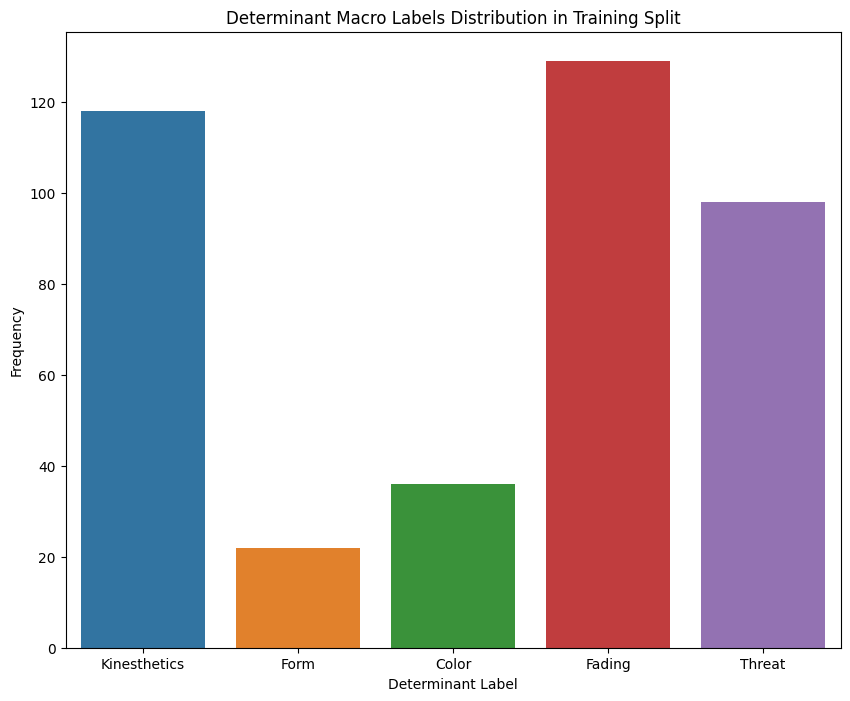

In [60]:
df_distribution_class_training = pd.DataFrame(distribution_class_training, index=[0])

df_distribution_class_training.columns = ["Kinesthetics", "Form", "Color", "Fading", "Threat"]

df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
# plt.xticks(fontsize=7.25)
plt.title("Determinant Macro Labels Distribution in Training Split")
ax.set_xlabel("Determinant Label")
ax.set_ylabel("Frequency")
plt.show()

In [58]:
distribution_class_val = count_class(val_df)
distribution_class_val

{'color_sum': 13,
 'threat_sum': 2,
 'fading_sum': 4,
 'form_sum': 14,
 'kinesthetics_sum': 11}

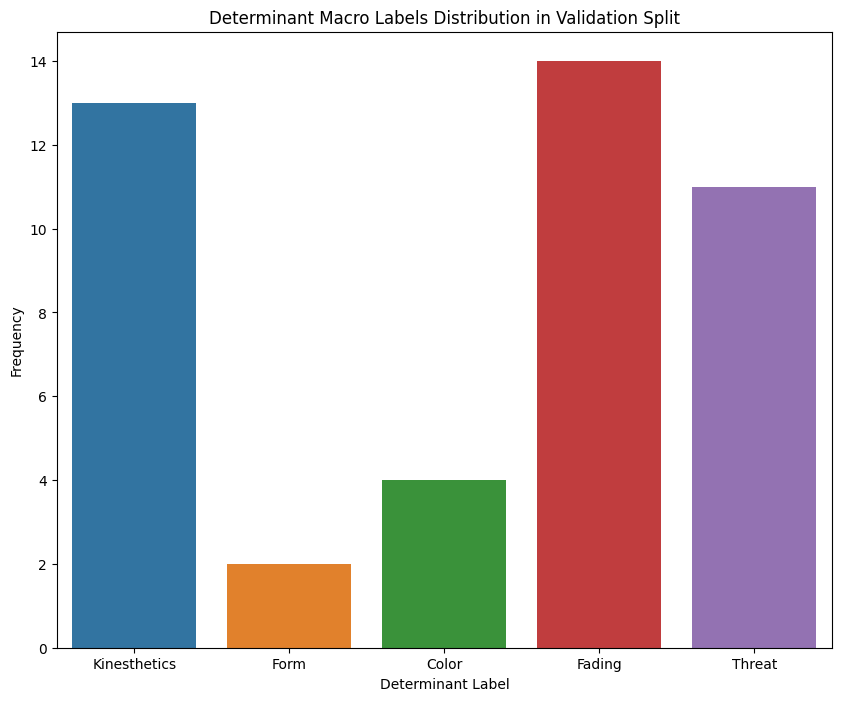

In [61]:
df_distribution_class_training = pd.DataFrame(distribution_class_val, index=[0])

df_distribution_class_training.columns = ["Kinesthetics", "Form", "Color", "Fading", "Threat"]

df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
# plt.xticks(fontsize=7.25)
plt.title("Determinant Macro Labels Distribution in Validation Split")
ax.set_xlabel("Determinant Label")
ax.set_ylabel("Frequency")
plt.show()

In [59]:
distribution_class_test = count_class(df_test)
distribution_class_test

{'color_sum': 7,
 'threat_sum': 1,
 'fading_sum': 2,
 'form_sum': 7,
 'kinesthetics_sum': 6}

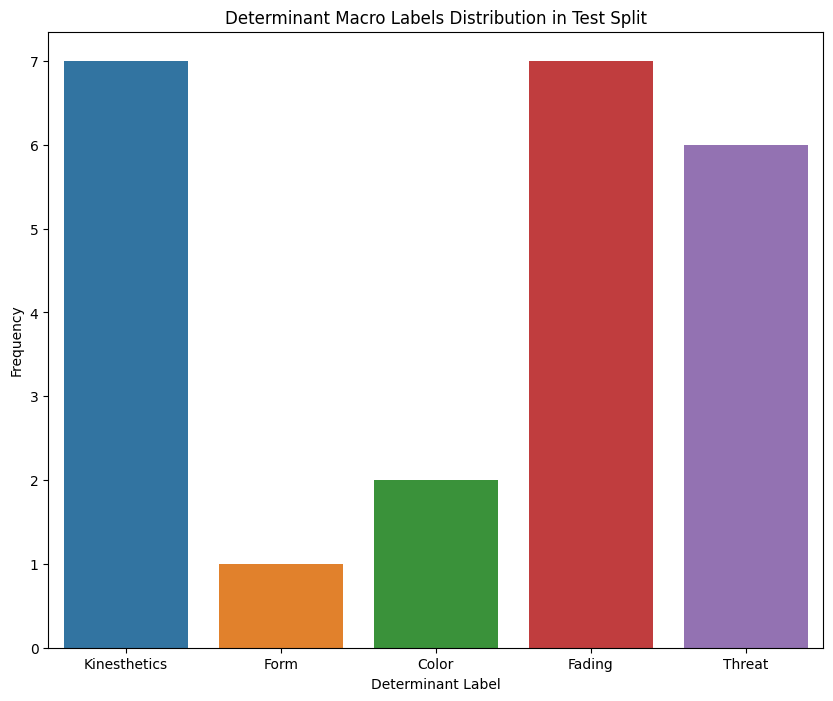

In [62]:
df_distribution_class_training = pd.DataFrame(distribution_class_test, index=[0])

df_distribution_class_training.columns = ["Kinesthetics", "Form", "Color", "Fading", "Threat"]

df_distribution_class_training = df_distribution_class_training.replace("no positive class", 0)
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_distribution_class_training)
# plt.xticks(fontsize=7.25)
plt.title("Determinant Macro Labels Distribution in Test Split")
ax.set_xlabel("Determinant Label")
ax.set_ylabel("Frequency")
plt.show()

### Training the model

In [36]:
i = 0
grid_metric_results = []
for hp_dictionary in param_grid_macro_dets:
    print(f"PARAM {i}/{n_grids}")
    print(hp_dictionary)

    # try:

    MAX_LEN, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE, EPOCHS, LEARNING_RATE = set_hyperparams(hp_dictionary)

    train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
    valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)
    test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

    train_data_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

    val_data_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    test_data_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )

    model = BERTClass()
    model.to(device)
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)


    ckpt_path = "curr_ckpt"
    best_model_path = "best_model.pt"

    trained_model, best_metrics = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path, df_labels)

    metrics, f1, roc_auc, hamming, accuracy, test_loss, metrics_proba, metrics_targets = compute_test_metrics(test_data_loader)

    best_metrics["test"] = {}
    best_metrics["test"]["test_loss"] = test_loss
    best_metrics["test"]["test_f1"] = f1
    best_metrics["test"]["test_roc_auc"] = roc_auc
    best_metrics["test"]["test_hamming"] = hamming
    best_metrics["test"]["test_accuracy"] = accuracy
    best_metrics["test"]["test_proba"] = metrics_proba
    best_metrics["test"]["test_actual_classes"] = metrics_targets

    result = {
          'hyperparameters': hp_dictionary,
          'metrics': best_metrics
      }

    grid_metric_results.append(result)
    i = i + 1

PARAM 0/3
{'max-len': 128, 'learning_rate': 2e-05, 'batch_size': 8, 'num_train_epochs': 40}


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1  Metrics   #############


{'roc_auc': 0.5, 'hamming_loss': 0.24444444444444444, 'f1': 0.0, 'accuracy_score': 0.0}
                  precision    recall  f1-score   support

       color_sum       0.00      0.00      0.00        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.00      0.00      0.00        14
kinesthetics_sum       0.00      0.00      0.00        11

       micro avg       0.00      0.00      0.00        44
       macro avg       0.00      0.00      0.00        44
    weighted avg       0.00      0.00      0.00        44
     samples avg       0.00      0.00      0.00        44

############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.013925 	Average Validati

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.633355614973262, 'hamming_loss': 0.20555555555555555, 'f1': 0.43076923076923074, 'accuracy_score': 0.2222222222222222}
                  precision    recall  f1-score   support

       color_sum       1.00      0.23      0.38        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.64      0.50      0.56        14
kinesthetics_sum       0.57      0.36      0.44        11

       micro avg       0.67      0.32      0.43        44
       macro avg       0.44      0.22      0.28        44
    weighted avg       0.64      0.32      0.40        44
     samples avg       0.32      0.30      0.30        44

############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.011682 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.6828208556149733, 'hamming_loss': 0.18888888888888888, 'f1': 0.5277777777777777, 'accuracy_score': 0.3888888888888889}
                  precision    recall  f1-score   support

       color_sum       0.71      0.38      0.50        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.65      0.79      0.71        14
kinesthetics_sum       0.75      0.27      0.40        11

       micro avg       0.68      0.43      0.53        44
       macro avg       0.42      0.29      0.32        44
    weighted avg       0.60      0.43      0.47        44
     samples avg       0.46      0.44      0.44        44

############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.009811 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.7282754010695187, 'hamming_loss': 0.16666666666666666, 'f1': 0.6052631578947368, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.86      0.46      0.60        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.63      0.86      0.73        14
kinesthetics_sum       0.83      0.45      0.59        11

       micro avg       0.72      0.52      0.61        44
       macro avg       0.46      0.35      0.38        44
    weighted avg       0.66      0.52      0.56        44
     samples avg       0.57      0.54      0.55        44

############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.007929 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.6945187165775402, 'hamming_loss': 0.19444444444444445, 'f1': 0.5454545454545454, 'accuracy_score': 0.4166666666666667}
                  precision    recall  f1-score   support

       color_sum       0.58      0.54      0.56        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.80      0.36      0.50        11

       micro avg       0.64      0.48      0.55        44
       macro avg       0.42      0.32      0.35        44
    weighted avg       0.60      0.48      0.52        44
     samples avg       0.52      0.50      0.50        44

############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.006174 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.7322860962566845, 'hamming_loss': 0.17222222222222222, 'f1': 0.6075949367088607, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.50      0.46      0.48        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.82      0.82      0.82        11

       micro avg       0.69      0.55      0.61        44
       macro avg       0.41      0.38      0.40        44
    weighted avg       0.59      0.55      0.57        44
     samples avg       0.62      0.57      0.58        44

############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.004652 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.7322860962566845, 'hamming_loss': 0.17222222222222222, 'f1': 0.6075949367088607, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.69      0.55      0.61        44
       macro avg       0.43      0.38      0.40        44
    weighted avg       0.61      0.55      0.57        44
     samples avg       0.56      0.55      0.54        44

############# Epoch 7: Validation End     #############
Epoch: 7 	Avgerage Training Loss: 0.003554 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.7359625668449198, 'hamming_loss': 0.16666666666666666, 'f1': 0.6153846153846153, 'accuracy_score': 0.5}
                  precision    recall  f1-score   support

       color_sum       0.60      0.69      0.64        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.83      0.45      0.59        11

       micro avg       0.71      0.55      0.62        44
       macro avg       0.44      0.37      0.39        44
    weighted avg       0.63      0.55      0.57        44
     samples avg       0.60      0.57      0.57        44

############# Epoch 8: Validation End     #############
Epoch: 8 	Avgerage Training Loss: 0.002820 	Average Validation Loss: 0.096162
######

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.7172459893048129, 'hamming_loss': 0.18333333333333332, 'f1': 0.5822784810126581, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.57      0.62      0.59        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       1.00      0.36      0.53        11

       micro avg       0.66      0.52      0.58        44
       macro avg       0.47      0.35      0.38        44
    weighted avg       0.67      0.52      0.56        44
     samples avg       0.56      0.54      0.54        44

############# Epoch 9: Validation End     #############
Epoch: 9 	Avgerage Training Loss: 0.002334 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.7245989304812834, 'hamming_loss': 0.17222222222222222, 'f1': 0.5974025974025974, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.67      0.77      0.71        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.80      0.36      0.50        11

       micro avg       0.70      0.52      0.60        44
       macro avg       0.44      0.36      0.38        44
    weighted avg       0.64      0.52      0.56        44
     samples avg       0.58      0.54      0.55        44

############# Epoch 10: Validation End     #############
Epoch: 10 	Avgerage Training Loss: 0.001959 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.7132352941176471, 'hamming_loss': 0.17777777777777778, 'f1': 0.5789473684210527, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       1.00      0.36      0.53        11

       micro avg       0.69      0.50      0.58        44
       macro avg       0.46      0.34      0.37        44
    weighted avg       0.65      0.50      0.54        44
     samples avg       0.58      0.53      0.55        44

############# Epoch 11: Validation End     #############
Epoch: 11 	Avgerage Training Loss: 0.001758 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.7135695187165776, 'hamming_loss': 0.18888888888888888, 'f1': 0.575, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.50      0.77      0.61        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       1.00      0.36      0.53        11

       micro avg       0.64      0.52      0.57        44
       macro avg       0.45      0.36      0.37        44
    weighted avg       0.64      0.52      0.53        44
     samples avg       0.60      0.54      0.55        44

############# Epoch 12: Validation End     #############
Epoch: 12 	Avgerage Training Loss: 0.001510 	Average Validation Loss: 0.105678

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.7550133689839572, 'hamming_loss': 0.16111111111111112, 'f1': 0.6419753086419754, 'accuracy_score': 0.5}
                  precision    recall  f1-score   support

       color_sum       0.55      0.46      0.50        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.80      0.86      0.83        14
kinesthetics_sum       0.78      0.64      0.70        11

       micro avg       0.70      0.59      0.64        44
       macro avg       0.52      0.49      0.51        44
    weighted avg       0.63      0.59      0.61        44
     samples avg       0.65      0.62      0.62        44

############# Epoch 13: Validation End     #############
Epoch: 13 	Avgerage Training Loss: 0.001317 	Average Validation Loss: 0.096829
#

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.7737299465240642, 'hamming_loss': 0.14444444444444443, 'f1': 0.6749999999999999, 'accuracy_score': 0.5}
                  precision    recall  f1-score   support

       color_sum       0.64      0.69      0.67        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.86      0.55      0.67        11

       micro avg       0.75      0.61      0.67        44
       macro avg       0.66      0.50      0.56        44
    weighted avg       0.70      0.61      0.64        44
     samples avg       0.65      0.61      0.62        44

############# Epoch 14: Validation End     #############
Epoch: 14 	Avgerage Training Loss: 0.001101 	Average Validation Loss: 0.102428
#

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.7322860962566845, 'hamming_loss': 0.17222222222222222, 'f1': 0.6075949367088607, 'accuracy_score': 0.4166666666666667}
                  precision    recall  f1-score   support

       color_sum       0.54      0.54      0.54        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.69      0.55      0.61        44
       macro avg       0.53      0.46      0.49        44
    weighted avg       0.64      0.55      0.59        44
     samples avg       0.60      0.56      0.56        44

############# Epoch 15: Validation End     #############
Epoch: 15 	Avgerage Training Loss: 0.000895 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.7135695187165776, 'hamming_loss': 0.18888888888888888, 'f1': 0.575, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.47      0.62      0.53        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       1.00      0.45      0.62        11

       micro avg       0.64      0.52      0.57        44
       macro avg       0.45      0.36      0.38        44
    weighted avg       0.63      0.52      0.55        44
     samples avg       0.58      0.54      0.55        44

############# Epoch 16: Validation End     #############
Epoch: 16 	Avgerage Training Loss: 0.000768 	Average Validation Loss: 0.112407

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.7359625668449198, 'hamming_loss': 0.16666666666666666, 'f1': 0.6153846153846153, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.55      0.46      0.50        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.71      0.55      0.62        44
       macro avg       0.54      0.46      0.50        44
    weighted avg       0.65      0.55      0.59        44
     samples avg       0.60      0.57      0.57        44

############# Epoch 17: Validation End     #############
Epoch: 17 	Avgerage Training Loss: 0.000682 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.7439839572192513, 'hamming_loss': 0.17777777777777778, 'f1': 0.6190476190476191, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.50      0.62      0.55        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.65      0.59      0.62        44
       macro avg       0.53      0.49      0.51        44
    weighted avg       0.63      0.59      0.61        44
     samples avg       0.61      0.59      0.59        44

############# Epoch 18: Validation End     #############
Epoch: 18 	Avgerage Training Loss: 0.000604 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.7436497326203209, 'hamming_loss': 0.16666666666666666, 'f1': 0.625, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.54      0.54      0.54        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.69      0.57      0.62        44
       macro avg       0.54      0.48      0.50        44
    weighted avg       0.65      0.57      0.60        44
     samples avg       0.60      0.58      0.58        44

############# Epoch 19: Validation End     #############
Epoch: 19 	Avgerage Training Loss: 0.000550 	Average Validation Loss: 0.114972

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.7399732620320856, 'hamming_loss': 0.17222222222222222, 'f1': 0.617283950617284, 'accuracy_score': 0.4166666666666667}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.68      0.57      0.62        44
       macro avg       0.53      0.48      0.50        44
    weighted avg       0.64      0.57      0.60        44
     samples avg       0.60      0.56      0.57        44

############# Epoch 20: Validation End     #############
Epoch: 20 	Avgerage Training Loss: 0.000495 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.7436497326203209, 'hamming_loss': 0.16666666666666666, 'f1': 0.625, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.54      0.54      0.54        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.69      0.57      0.62        44
       macro avg       0.54      0.48      0.50        44
    weighted avg       0.65      0.57      0.60        44
     samples avg       0.60      0.58      0.58        44

############# Epoch 21: Validation End     #############
Epoch: 21 	Avgerage Training Loss: 0.000465 	Average Validation Loss: 0.115967

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.7513368983957219, 'hamming_loss': 0.16666666666666666, 'f1': 0.6341463414634148, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.56      0.69      0.62        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.68      0.59      0.63        44
       macro avg       0.64      0.49      0.54        44
    weighted avg       0.67      0.59      0.62        44
     samples avg       0.62      0.59      0.60        44

############# Epoch 22: Validation End     #############
Epoch: 22 	Avgerage Training Loss: 0.000425 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.7326203208556151, 'hamming_loss': 0.18333333333333332, 'f1': 0.6024096385542169, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.50      0.54      0.52        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.64      0.57      0.60        44
       macro avg       0.53      0.48      0.50        44
    weighted avg       0.63      0.57      0.60        44
     samples avg       0.59      0.58      0.57        44

############# Epoch 23: Validation End     #############
Epoch: 23 	Avgerage Training Loss: 0.000407 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.7473262032085563, 'hamming_loss': 0.16111111111111112, 'f1': 0.6329113924050633, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.58      0.54      0.56        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.71      0.57      0.63        44
       macro avg       0.55      0.48      0.51        44
    weighted avg       0.66      0.57      0.61        44
     samples avg       0.60      0.58      0.58        44

############# Epoch 24: Validation End     #############
Epoch: 24 	Avgerage Training Loss: 0.000363 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.7399732620320856, 'hamming_loss': 0.17222222222222222, 'f1': 0.617283950617284, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.86      0.55      0.67        11

       micro avg       0.68      0.57      0.62        44
       macro avg       0.53      0.48      0.50        44
    weighted avg       0.64      0.57      0.59        44
     samples avg       0.61      0.59      0.59        44

############# Epoch 25: Validation End     #############
Epoch: 25 	Avgerage Training Loss: 0.000360 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.7513368983957219, 'hamming_loss': 0.16666666666666666, 'f1': 0.6341463414634148, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.68      0.59      0.63        44
       macro avg       0.54      0.49      0.51        44
    weighted avg       0.64      0.59      0.61        44
     samples avg       0.62      0.61      0.60        44

############# Epoch 26: Validation End     #############
Epoch: 26 	Avgerage Training Loss: 0.000331 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.7476604278074865, 'hamming_loss': 0.17222222222222222, 'f1': 0.6265060240963856, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.50      0.62      0.55        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.67      0.59      0.63        44
       macro avg       0.53      0.49      0.51        44
    weighted avg       0.63      0.59      0.61        44
     samples avg       0.61      0.61      0.60        44

############# Epoch 27: Validation End     #############
Epoch: 27 	Avgerage Training Loss: 0.000311 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.7627005347593584, 'hamming_loss': 0.16111111111111112, 'f1': 0.6506024096385543, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.56      0.69      0.62        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.69      0.61      0.65        44
       macro avg       0.54      0.51      0.52        44
    weighted avg       0.65      0.61      0.63        44
     samples avg       0.65      0.62      0.62        44

############# Epoch 28: Validation End     #############
Epoch: 28 	Avgerage Training Loss: 0.000293 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.7359625668449198, 'hamming_loss': 0.16666666666666666, 'f1': 0.6153846153846153, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.55      0.46      0.50        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.78      0.64      0.70        11

       micro avg       0.71      0.55      0.62        44
       macro avg       0.62      0.46      0.52        44
    weighted avg       0.65      0.55      0.59        44
     samples avg       0.61      0.57      0.57        44

############# Epoch 29: Validation End     #############
Epoch: 29 	Avgerage Training Loss: 0.000290 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.7476604278074865, 'hamming_loss': 0.17222222222222222, 'f1': 0.6265060240963856, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.67      0.59      0.63        44
       macro avg       0.54      0.49      0.51        44
    weighted avg       0.64      0.59      0.61        44
     samples avg       0.62      0.61      0.60        44

############# Epoch 30: Validation End     #############
Epoch: 30 	Avgerage Training Loss: 0.000280 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.7476604278074865, 'hamming_loss': 0.17222222222222222, 'f1': 0.6265060240963856, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.67      0.59      0.63        44
       macro avg       0.54      0.49      0.51        44
    weighted avg       0.64      0.59      0.61        44
     samples avg       0.62      0.61      0.60        44

############# Epoch 31: Validation End     #############
Epoch: 31 	Avgerage Training Loss: 0.000259 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.7550133689839572, 'hamming_loss': 0.16111111111111112, 'f1': 0.6419753086419754, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.64      0.69      0.67        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.86      0.55      0.67        11

       micro avg       0.70      0.59      0.64        44
       macro avg       0.55      0.49      0.51        44
    weighted avg       0.67      0.59      0.62        44
     samples avg       0.64      0.61      0.61        44

############# Epoch 32: Validation End     #############
Epoch: 32 	Avgerage Training Loss: 0.000251 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.7550133689839572, 'hamming_loss': 0.16111111111111112, 'f1': 0.6419753086419754, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.62      0.62      0.62        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.70      0.59      0.64        44
       macro avg       0.55      0.49      0.52        44
    weighted avg       0.67      0.59      0.62        44
     samples avg       0.62      0.61      0.60        44

############# Epoch 33: Validation End     #############
Epoch: 33 	Avgerage Training Loss: 0.000242 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.7399732620320856, 'hamming_loss': 0.17222222222222222, 'f1': 0.617283950617284, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.86      0.55      0.67        11

       micro avg       0.68      0.57      0.62        44
       macro avg       0.53      0.48      0.50        44
    weighted avg       0.64      0.57      0.59        44
     samples avg       0.61      0.59      0.59        44

############# Epoch 34: Validation End     #############
Epoch: 34 	Avgerage Training Loss: 0.000232 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.7553475935828878, 'hamming_loss': 0.17222222222222222, 'f1': 0.6352941176470588, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.56      0.69      0.62        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.66      0.61      0.64        44
       macro avg       0.54      0.51      0.52        44
    weighted avg       0.65      0.61      0.63        44
     samples avg       0.64      0.62      0.62        44

############# Epoch 35: Validation End     #############
Epoch: 35 	Avgerage Training Loss: 0.000218 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.7473262032085563, 'hamming_loss': 0.16111111111111112, 'f1': 0.6329113924050633, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.58      0.54      0.56        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.71      0.57      0.63        44
       macro avg       0.55      0.48      0.51        44
    weighted avg       0.66      0.57      0.61        44
     samples avg       0.62      0.60      0.60        44

############# Epoch 36: Validation End     #############
Epoch: 36 	Avgerage Training Loss: 0.000202 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.740307486631016, 'hamming_loss': 0.18333333333333332, 'f1': 0.611764705882353, 'accuracy_score': 0.4166666666666667}
                  precision    recall  f1-score   support

       color_sum       0.53      0.69      0.60        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.63      0.59      0.61        44
       macro avg       0.53      0.49      0.51        44
    weighted avg       0.64      0.59      0.60        44
     samples avg       0.60      0.59      0.58        44

############# Epoch 37: Validation End     #############
Epoch: 37 	Avgerage Training Loss: 0.000195 	Average Validation Los

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.7439839572192513, 'hamming_loss': 0.17777777777777778, 'f1': 0.6190476190476191, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.53      0.69      0.60        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.65      0.59      0.62        44
       macro avg       0.63      0.49      0.54        44
    weighted avg       0.66      0.59      0.61        44
     samples avg       0.61      0.59      0.59        44

############# Epoch 38: Validation End     #############
Epoch: 38 	Avgerage Training Loss: 0.000187 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.7399732620320856, 'hamming_loss': 0.17222222222222222, 'f1': 0.617283950617284, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.53      0.62      0.57        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.75      0.64      0.69        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.68      0.57      0.62        44
       macro avg       0.63      0.48      0.53        44
    weighted avg       0.66      0.57      0.60        44
     samples avg       0.60      0.58      0.58        44

############# Epoch 39: Validation End     #############
Epoch: 39 	Avgerage Training Loss: 0.000180 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.7513368983957219, 'hamming_loss': 0.16666666666666666, 'f1': 0.6341463414634148, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.56      0.69      0.62        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.86      0.55      0.67        11

       micro avg       0.68      0.59      0.63        44
       macro avg       0.64      0.49      0.54        44
    weighted avg       0.67      0.59      0.62        44
     samples avg       0.64      0.61      0.61        44

############# Epoch 40: Validation End     #############
Epoch: 40 	Avgerage Training Loss: 0.000169 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'roc_auc': 0.6645035691109669, 'hamming_loss': 0.24444444444444444, 'f1': 0.5, 'accuracy_score': 0.3333333333333333}
                  precision    recall  f1-score   support

       color_sum       0.29      0.29      0.29         7
      threat_sum       0.00      0.00      0.00         1
      fading_sum       1.00      0.50      0.67         2
        form_sum       0.50      0.57      0.53         7
kinesthetics_sum       0.80      0.67      0.73         6

       micro avg       0.52      0.48      0.50        23
       macro avg       0.52      0.40      0.44        23
    weighted avg       0.53      0.48      0.50        23
     samples avg       0.48      0.47      0.47        23

PARAM 1/3
{'max-len': 128, 'learning_rate': 5e-05, 'batch_size': 8, 'num_train_epochs': 40}
############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1  Metrics   ##########

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.720922459893048, 'hamming_loss': 0.17777777777777778, 'f1': 0.5897435897435898, 'accuracy_score': 0.4166666666666667}
                  precision    recall  f1-score   support

       color_sum       0.67      0.62      0.64        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.50      0.25      0.33         4
        form_sum       0.60      0.43      0.50        14
kinesthetics_sum       0.80      0.73      0.76        11

       micro avg       0.68      0.52      0.59        44
       macro avg       0.51      0.40      0.45        44
    weighted avg       0.63      0.52      0.57        44
     samples avg       0.54      0.50      0.51        44

############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.010518 	Average Validation Loss: 0

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.7777406417112299, 'hamming_loss': 0.15, 'f1': 0.674698795180723, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.73      0.62      0.67        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.67      0.71      0.69        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.72      0.64      0.67        44
       macro avg       0.45      0.45      0.45        44
    weighted avg       0.64      0.64      0.63        44
     samples avg       0.70      0.65      0.66        44

############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.007481 	Average Validation Loss: 0.075530
Validat

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.8001336898395722, 'hamming_loss': 0.12777777777777777, 'f1': 0.7160493827160493, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.75      0.69      0.72        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       1.00      0.73      0.84        11

       micro avg       0.78      0.66      0.72        44
       macro avg       0.70      0.54      0.60        44
    weighted avg       0.75      0.66      0.69        44
     samples avg       0.74      0.68      0.69        44

############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.004608 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.7891042780748663, 'hamming_loss': 0.14444444444444443, 'f1': 0.6904761904761905, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.71      0.77      0.74        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.80      0.73      0.76        11

       micro avg       0.72      0.66      0.69        44
       macro avg       0.65      0.54      0.58        44
    weighted avg       0.68      0.66      0.67        44
     samples avg       0.70      0.66      0.67        44

############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.003207 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.7740641711229946, 'hamming_loss': 0.15555555555555556, 'f1': 0.6666666666666666, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.64      0.54      0.58        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.67      0.71      0.69        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.70      0.64      0.67        44
       macro avg       0.63      0.53      0.56        44
    weighted avg       0.65      0.64      0.64        44
     samples avg       0.70      0.65      0.66        44

############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.002330 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.7703877005347592, 'hamming_loss': 0.16111111111111112, 'f1': 0.6588235294117647, 'accuracy_score': 0.5}
                  precision    recall  f1-score   support

       color_sum       0.64      0.69      0.67        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.69      0.64      0.67        14
kinesthetics_sum       0.75      0.82      0.78        11

       micro avg       0.68      0.64      0.66        44
       macro avg       0.62      0.53      0.56        44
    weighted avg       0.64      0.64      0.64        44
     samples avg       0.66      0.63      0.63        44

############# Epoch 7: Validation End     #############
Epoch: 7 	Avgerage Training Loss: 0.001597 	Average Validation Loss: 0.082748
######

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.7931149732620321, 'hamming_loss': 0.15, 'f1': 0.6896551724137931, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.78      0.54      0.64        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.50      0.25      0.33         4
        form_sum       0.69      0.79      0.73        14
kinesthetics_sum       0.67      0.91      0.77        11

       micro avg       0.70      0.68      0.69        44
       macro avg       0.73      0.60      0.63        44
    weighted avg       0.71      0.68      0.67        44
     samples avg       0.73      0.71      0.70        44

############# Epoch 8: Validation End     #############
Epoch: 8 	Avgerage Training Loss: 0.001081 	Average Validation Loss: 0.088451
######

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.8228609625668449, 'hamming_loss': 0.11666666666666667, 'f1': 0.746987951807229, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.71      0.77      0.74        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       1.00      0.91      0.95        11

       micro avg       0.79      0.70      0.75        44
       macro avg       0.69      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.72      0.69      0.70        44

############# Epoch 10: Validation End     #############
Epoch: 10 	Avgerage Training Loss: 0.000726 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.8155080213903744, 'hamming_loss': 0.12777777777777777, 'f1': 0.7294117647058823, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       0.50      0.50      0.50         2
      fading_sum       0.50      0.25      0.33         4
        form_sum       0.69      0.64      0.67        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.76      0.70      0.73        44
       macro avg       0.67      0.61      0.64        44
    weighted avg       0.74      0.70      0.72        44
     samples avg       0.69      0.69      0.68        44

############# Epoch 11: Validation End     #############
Epoch: 11 	Avgerage Training Loss: 0.000580 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.72      0.72      0.71        44

############# Epoch 12: Validation End     #############
Epoch: 12 	Avgerage Training Loss: 0.000431 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.8155080213903744, 'hamming_loss': 0.12777777777777777, 'f1': 0.7294117647058823, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.76      0.70      0.73        44
       macro avg       0.66      0.58      0.60        44
    weighted avg       0.71      0.70      0.70        44
     samples avg       0.69      0.69      0.68        44

############# Epoch 13: Validation End     #############
Epoch: 13 	Avgerage Training Loss: 0.000346 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.8155080213903744, 'hamming_loss': 0.12777777777777777, 'f1': 0.7294117647058823, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.76      0.70      0.73        44
       macro avg       0.66      0.58      0.60        44
    weighted avg       0.71      0.70      0.70        44
     samples avg       0.69      0.69      0.68        44

############# Epoch 14: Validation End     #############
Epoch: 14 	Avgerage Training Loss: 0.000298 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.8078208556149732, 'hamming_loss': 0.12777777777777777, 'f1': 0.7228915662650602, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.71      0.77      0.74        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       1.00      0.82      0.90        11

       micro avg       0.77      0.68      0.72        44
       macro avg       0.69      0.56      0.60        44
    weighted avg       0.73      0.68      0.70        44
     samples avg       0.71      0.68      0.68        44

############# Epoch 15: Validation End     #############
Epoch: 15 	Avgerage Training Loss: 0.000271 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.8078208556149732, 'hamming_loss': 0.12777777777777777, 'f1': 0.7228915662650602, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.77      0.68      0.72        44
       macro avg       0.68      0.56      0.60        44
    weighted avg       0.72      0.68      0.70        44
     samples avg       0.71      0.68      0.68        44

############# Epoch 16: Validation End     #############
Epoch: 16 	Avgerage Training Loss: 0.000237 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.8228609625668449, 'hamming_loss': 0.11666666666666667, 'f1': 0.746987951807229, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.79      0.70      0.75        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.72      0.69      0.70        44

############# Epoch 17: Validation End     #############
Epoch: 17 	Avgerage Training Loss: 0.000220 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.66      0.58      0.60        44
    weighted avg       0.71      0.70      0.70        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 18: Validation End     #############
Epoch: 18 	Avgerage Training Loss: 0.000195 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 19: Validation End     #############
Epoch: 19 	Avgerage Training Loss: 0.000181 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.8078208556149732, 'hamming_loss': 0.12777777777777777, 'f1': 0.7228915662650602, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.77      0.68      0.72        44
       macro avg       0.68      0.56      0.60        44
    weighted avg       0.72      0.68      0.70        44
     samples avg       0.71      0.68      0.68        44

############# Epoch 20: Validation End     #############
Epoch: 20 	Avgerage Training Loss: 0.000171 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.8078208556149732, 'hamming_loss': 0.12777777777777777, 'f1': 0.7228915662650602, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.75      0.69      0.72        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.77      0.68      0.72        44
       macro avg       0.68      0.56      0.60        44
    weighted avg       0.73      0.68      0.70        44
     samples avg       0.74      0.69      0.70        44

############# Epoch 21: Validation End     #############
Epoch: 21 	Avgerage Training Loss: 0.000155 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.8155080213903744, 'hamming_loss': 0.12777777777777777, 'f1': 0.7294117647058823, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.75      0.69      0.72        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.76      0.70      0.73        44
       macro avg       0.66      0.58      0.60        44
    weighted avg       0.71      0.70      0.70        44
     samples avg       0.72      0.70      0.70        44

############# Epoch 22: Validation End     #############
Epoch: 22 	Avgerage Training Loss: 0.000147 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 23: Validation End     #############
Epoch: 23 	Avgerage Training Loss: 0.000137 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.57      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.74      0.70      0.71        44

############# Epoch 24: Validation End     #############
Epoch: 24 	Avgerage Training Loss: 0.000131 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.8228609625668449, 'hamming_loss': 0.11666666666666667, 'f1': 0.746987951807229, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.75      0.69      0.72        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.79      0.70      0.75        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.75      0.70      0.72        44

############# Epoch 25: Validation End     #############
Epoch: 25 	Avgerage Training Loss: 0.000121 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 26: Validation End     #############
Epoch: 26 	Avgerage Training Loss: 0.000116 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 27: Training End     #############
############# Epoch 27: Validation Start   #############
############# Epoch 27  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 27: Validation End     #############
Epoch: 27 	Avgerage Training Loss: 0.000105 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 28: Validation End     #############
Epoch: 28 	Avgerage Training Loss: 0.000103 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 29: Validation End     #############
Epoch: 29 	Avgerage Training Loss: 0.000098 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 30: Training End     #############
############# Epoch 30: Validation Start   #############
############# Epoch 30  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 30: Validation End     #############
Epoch: 30 	Avgerage Training Loss: 0.000091 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 31: Validation End     #############
Epoch: 31 	Avgerage Training Loss: 0.000087 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 32: Training End     #############
############# Epoch 32: Validation Start   #############
############# Epoch 32  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 32: Validation End     #############
Epoch: 32 	Avgerage Training Loss: 0.000083 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 33: Training End     #############
############# Epoch 33: Validation Start   #############
############# Epoch 33  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 33: Validation End     #############
Epoch: 33 	Avgerage Training Loss: 0.000078 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 34: Training End     #############
############# Epoch 34: Validation Start   #############
############# Epoch 34  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.75      0.69      0.72        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.74      0.70      0.71        44

############# Epoch 34: Validation End     #############
Epoch: 34 	Avgerage Training Loss: 0.000076 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 35: Training End     #############
############# Epoch 35: Validation Start   #############
############# Epoch 35  Metrics   #############


{'roc_auc': 0.8191844919786097, 'hamming_loss': 0.12222222222222222, 'f1': 0.7380952380952381, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.70      0.74        44
       macro avg       0.68      0.58      0.61        44
    weighted avg       0.73      0.70      0.71        44
     samples avg       0.71      0.69      0.69        44

############# Epoch 35: Validation End     #############
Epoch: 35 	Avgerage Training Loss: 0.000072 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 36: Validation End     #############
Epoch: 36 	Avgerage Training Loss: 0.000070 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 37: Validation End     #############
Epoch: 37 	Avgerage Training Loss: 0.000066 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 38: Training End     #############
############# Epoch 38: Validation Start   #############
############# Epoch 38  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 38: Validation End     #############
Epoch: 38 	Avgerage Training Loss: 0.000065 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 39: Validation End     #############
Epoch: 39 	Avgerage Training Loss: 0.000060 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############
############# Epoch 40  Metrics   #############


{'roc_auc': 0.830548128342246, 'hamming_loss': 0.11666666666666667, 'f1': 0.7529411764705882, 'accuracy_score': 0.6388888888888888}
                  precision    recall  f1-score   support

       color_sum       0.77      0.77      0.77        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.78      0.73      0.75        44
       macro avg       0.68      0.59      0.62        44
    weighted avg       0.73      0.73      0.73        44
     samples avg       0.74      0.72      0.72        44

############# Epoch 40: Validation End     #############
Epoch: 40 	Avgerage Training Loss: 0.000058 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'roc_auc': 0.6502271252433485, 'hamming_loss': 0.24444444444444444, 'f1': 0.47619047619047616, 'accuracy_score': 0.3888888888888889}
                  precision    recall  f1-score   support

       color_sum       0.43      0.43      0.43         7
      threat_sum       0.00      0.00      0.00         1
      fading_sum       1.00      0.50      0.67         2
        form_sum       0.43      0.43      0.43         7
kinesthetics_sum       0.75      0.50      0.60         6

       micro avg       0.53      0.43      0.48        23
       macro avg       0.52      0.37      0.42        23
    weighted avg       0.54      0.43      0.48        23
     samples avg       0.50      0.44      0.46        23

PARAM 2/3
{'max-len': 128, 'learning_rate': 5e-05, 'batch_size': 12, 'num_train_epochs': 40}
############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1  Met

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2  Metrics   #############


{'roc_auc': 0.6570855614973262, 'hamming_loss': 0.22777777777777777, 'f1': 0.4810126582278481, 'accuracy_score': 0.25}
                  precision    recall  f1-score   support

       color_sum       0.55      0.46      0.50        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.57      0.57      0.57        14
kinesthetics_sum       0.50      0.45      0.48        11

       micro avg       0.54      0.43      0.48        44
       macro avg       0.32      0.30      0.31        44
    weighted avg       0.47      0.43      0.45        44
     samples avg       0.39      0.41      0.39        44

############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.016910 	Average Validation Loss: 0.153253
Valid

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epoch 3  Metrics   #############


{'roc_auc': 0.7479946524064172, 'hamming_loss': 0.18333333333333332, 'f1': 0.6206896551724139, 'accuracy_score': 0.5}
                  precision    recall  f1-score   support

       color_sum       0.64      0.69      0.67        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.50      0.50      0.50         4
        form_sum       0.67      0.71      0.69        14
kinesthetics_sum       0.60      0.55      0.57        11

       micro avg       0.63      0.61      0.62        44
       macro avg       0.48      0.49      0.49        44
    weighted avg       0.60      0.61      0.60        44
     samples avg       0.57      0.60      0.57        44

############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.014442 	Average Validation Loss: 0.141072
Valida

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 4: Training End     #############
############# Epoch 4: Validation Start   #############
############# Epoch 4  Metrics   #############


{'roc_auc': 0.7469919786096256, 'hamming_loss': 0.15, 'f1': 0.64, 'accuracy_score': 0.4722222222222222}
                  precision    recall  f1-score   support

       color_sum       0.78      0.54      0.64        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.78      0.64      0.70        11

       micro avg       0.77      0.55      0.64        44
       macro avg       0.46      0.38      0.42        44
    weighted avg       0.67      0.55      0.60        44
     samples avg       0.58      0.54      0.55        44

############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.011010 	Average Validation Loss: 0.122432
Validation loss decr

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 5: Training End     #############
############# Epoch 5: Validation Start   #############
############# Epoch 5  Metrics   #############


{'roc_auc': 0.7369652406417113, 'hamming_loss': 0.2, 'f1': 0.6, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.50      0.77      0.61        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.64      0.50      0.56        14
kinesthetics_sum       0.71      0.91      0.80        11

       micro avg       0.59      0.61      0.60        44
       macro avg       0.37      0.44      0.39        44
    weighted avg       0.53      0.61      0.56        44
     samples avg       0.58      0.59      0.57        44

############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.007522 	Average Validation Loss: 0.147123
############# Epoch 5 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 6: Training End     #############
############# Epoch 6: Validation Start   #############
############# Epoch 6  Metrics   #############


{'roc_auc': 0.7282754010695187, 'hamming_loss': 0.16666666666666666, 'f1': 0.6052631578947368, 'accuracy_score': 0.5277777777777778}
                  precision    recall  f1-score   support

       color_sum       0.73      0.62      0.67        13
      threat_sum       0.00      0.00      0.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.65      0.79      0.71        14
kinesthetics_sum       1.00      0.36      0.53        11

       micro avg       0.72      0.52      0.61        44
       macro avg       0.47      0.35      0.38        44
    weighted avg       0.67      0.52      0.56        44
     samples avg       0.64      0.57      0.59        44

############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.005017 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 7: Training End     #############
############# Epoch 7: Validation Start   #############
############# Epoch 7  Metrics   #############


{'roc_auc': 0.7172459893048129, 'hamming_loss': 0.18333333333333332, 'f1': 0.5822784810126581, 'accuracy_score': 0.4444444444444444}
                  precision    recall  f1-score   support

       color_sum       0.60      0.69      0.64        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.71      0.71      0.71        14
kinesthetics_sum       0.60      0.27      0.37        11

       micro avg       0.66      0.52      0.58        44
       macro avg       0.58      0.44      0.48        44
    weighted avg       0.60      0.52      0.54        44
     samples avg       0.58      0.56      0.55        44

############# Epoch 7: Validation End     #############
Epoch: 7 	Avgerage Training Loss: 0.003568 	Average Validation Loss: 

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 8: Training End     #############
############# Epoch 8: Validation Start   #############
############# Epoch 8  Metrics   #############


{'roc_auc': 0.811831550802139, 'hamming_loss': 0.13333333333333333, 'f1': 0.7209302325581395, 'accuracy_score': 0.5277777777777778}
                  precision    recall  f1-score   support

       color_sum       0.69      0.69      0.69        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.74      0.70      0.72        44
       macro avg       0.65      0.58      0.60        44
    weighted avg       0.69      0.70      0.69        44
     samples avg       0.70      0.70      0.69        44

############# Epoch 8: Validation End     #############
Epoch: 8 	Avgerage Training Loss: 0.002708 	Average Validation Loss: 0

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 9: Training End     #############
############# Epoch 9: Validation Start   #############
############# Epoch 9  Metrics   #############


{'roc_auc': 0.8081550802139038, 'hamming_loss': 0.1388888888888889, 'f1': 0.7126436781609196, 'accuracy_score': 0.5277777777777778}
                  precision    recall  f1-score   support

       color_sum       0.60      0.69      0.64        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.72      0.70      0.71        44
       macro avg       0.63      0.58      0.59        44
    weighted avg       0.66      0.70      0.68        44
     samples avg       0.70      0.70      0.69        44

############# Epoch 9: Validation End     #############
Epoch: 9 	Avgerage Training Loss: 0.002004 	Average Validation Loss: 0

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 10: Training End     #############
############# Epoch 10: Validation Start   #############
############# Epoch 10  Metrics   #############


{'roc_auc': 0.7894385026737967, 'hamming_loss': 0.15555555555555556, 'f1': 0.6818181818181818, 'accuracy_score': 0.5}
                  precision    recall  f1-score   support

       color_sum       0.59      0.77      0.67        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.80      0.73      0.76        11

       micro avg       0.68      0.68      0.68        44
       macro avg       0.63      0.56      0.58        44
    weighted avg       0.67      0.68      0.67        44
     samples avg       0.65      0.68      0.65        44

############# Epoch 10: Validation End     #############
Epoch: 10 	Avgerage Training Loss: 0.001485 	Average Validation Loss: 0.146886
#

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 11: Training End     #############
############# Epoch 11: Validation Start   #############
############# Epoch 11  Metrics   #############


{'roc_auc': 0.7513368983957219, 'hamming_loss': 0.16666666666666666, 'f1': 0.6341463414634148, 'accuracy_score': 0.5}
                  precision    recall  f1-score   support

       color_sum       0.62      0.77      0.69        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       1.00      0.36      0.53        11

       micro avg       0.68      0.59      0.63        44
       macro avg       0.67      0.48      0.53        44
    weighted avg       0.71      0.59      0.61        44
     samples avg       0.65      0.61      0.62        44

############# Epoch 11: Validation End     #############
Epoch: 11 	Avgerage Training Loss: 0.001265 	Average Validation Loss: 0.145521
#

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 12: Training End     #############
############# Epoch 12: Validation Start   #############
############# Epoch 12  Metrics   #############


{'roc_auc': 0.7550133689839572, 'hamming_loss': 0.16111111111111112, 'f1': 0.6419753086419754, 'accuracy_score': 0.5277777777777778}
                  precision    recall  f1-score   support

       color_sum       0.56      0.69      0.62        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.73      0.79      0.76        14
kinesthetics_sum       1.00      0.45      0.62        11

       micro avg       0.70      0.59      0.64        44
       macro avg       0.66      0.49      0.53        44
    weighted avg       0.69      0.59      0.61        44
     samples avg       0.67      0.62      0.63        44

############# Epoch 12: Validation End     #############
Epoch: 12 	Avgerage Training Loss: 0.001119 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 13: Training End     #############
############# Epoch 13: Validation Start   #############
############# Epoch 13  Metrics   #############


{'roc_auc': 0.8268716577540107, 'hamming_loss': 0.12222222222222222, 'f1': 0.7441860465116279, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.67      0.77      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.76      0.73      0.74        44
       macro avg       0.66      0.59      0.61        44
    weighted avg       0.70      0.73      0.71        44
     samples avg       0.71      0.72      0.71        44

############# Epoch 13: Validation End     #############
Epoch: 13 	Avgerage Training Loss: 0.000868 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 14: Training End     #############
############# Epoch 14: Validation Start   #############
############# Epoch 14  Metrics   #############


{'roc_auc': 0.8041443850267379, 'hamming_loss': 0.13333333333333333, 'f1': 0.7142857142857143, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.62      0.77      0.69        13
      threat_sum       1.00      1.00      1.00         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.88      0.64      0.74        11

       micro avg       0.75      0.68      0.71        44
       macro avg       0.66      0.64      0.64        44
    weighted avg       0.70      0.68      0.68        44
     samples avg       0.69      0.68      0.67        44

############# Epoch 14: Validation End     #############
Epoch: 14 	Avgerage Training Loss: 0.000686 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 15: Training End     #############
############# Epoch 15: Validation Start   #############
############# Epoch 15  Metrics   #############


{'roc_auc': 0.8155080213903744, 'hamming_loss': 0.12777777777777777, 'f1': 0.7294117647058823, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.67      0.77      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.76      0.70      0.73        44
       macro avg       0.65      0.58      0.60        44
    weighted avg       0.70      0.70      0.69        44
     samples avg       0.72      0.70      0.70        44

############# Epoch 15: Validation End     #############
Epoch: 15 	Avgerage Training Loss: 0.000571 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 16: Training End     #############
############# Epoch 16: Validation Start   #############
############# Epoch 16  Metrics   #############


{'roc_auc': 0.8231951871657753, 'hamming_loss': 0.12777777777777777, 'f1': 0.735632183908046, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.91      0.91      0.91        11

       micro avg       0.74      0.73      0.74        44
       macro avg       0.66      0.59      0.61        44
    weighted avg       0.70      0.73      0.70        44
     samples avg       0.71      0.72      0.71        44

############# Epoch 16: Validation End     #############
Epoch: 16 	Avgerage Training Loss: 0.000500 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 17: Training End     #############
############# Epoch 17: Validation Start   #############
############# Epoch 17  Metrics   #############


{'roc_auc': 0.8121657754010696, 'hamming_loss': 0.14444444444444443, 'f1': 0.711111111111111, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.58      0.85      0.69        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.70      0.73      0.71        44
       macro avg       0.64      0.59      0.59        44
    weighted avg       0.67      0.73      0.69        44
     samples avg       0.69      0.72      0.69        44

############# Epoch 17: Validation End     #############
Epoch: 17 	Avgerage Training Loss: 0.000466 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19  Metrics   #############


{'roc_auc': 0.811831550802139, 'hamming_loss': 0.13333333333333333, 'f1': 0.7209302325581395, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.77      0.71      0.74        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.74      0.70      0.72        44
       macro avg       0.66      0.58      0.59        44
    weighted avg       0.70      0.70      0.69        44
     samples avg       0.71      0.70      0.70        44

############# Epoch 19: Validation End     #############
Epoch: 19 	Avgerage Training Loss: 0.000379 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 20: Training End     #############
############# Epoch 20: Validation Start   #############
############# Epoch 20  Metrics   #############


{'roc_auc': 0.8308823529411764, 'hamming_loss': 0.12777777777777777, 'f1': 0.7415730337078651, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.73      0.75      0.74        44
       macro avg       0.65      0.61      0.61        44
    weighted avg       0.68      0.75      0.71        44
     samples avg       0.73      0.75      0.72        44

############# Epoch 20: Validation End     #############
Epoch: 20 	Avgerage Training Loss: 0.000347 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 21: Training End     #############
############# Epoch 21: Validation Start   #############
############# Epoch 21  Metrics   #############


{'roc_auc': 0.8231951871657753, 'hamming_loss': 0.12777777777777777, 'f1': 0.735632183908046, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.65      0.85      0.73        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.74      0.73      0.74        44
       macro avg       0.67      0.59      0.61        44
    weighted avg       0.71      0.73      0.71        44
     samples avg       0.74      0.73      0.72        44

############# Epoch 21: Validation End     #############
Epoch: 21 	Avgerage Training Loss: 0.000325 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 22: Training End     #############
############# Epoch 22: Validation Start   #############
############# Epoch 22  Metrics   #############


{'roc_auc': 0.8231951871657753, 'hamming_loss': 0.12777777777777777, 'f1': 0.735632183908046, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.74      0.73      0.74        44
       macro avg       0.66      0.59      0.60        44
    weighted avg       0.70      0.73      0.70        44
     samples avg       0.74      0.73      0.72        44

############# Epoch 22: Validation End     #############
Epoch: 22 	Avgerage Training Loss: 0.000307 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 23: Training End     #############
############# Epoch 23: Validation Start   #############
############# Epoch 23  Metrics   #############


{'roc_auc': 0.8308823529411764, 'hamming_loss': 0.12777777777777777, 'f1': 0.7415730337078651, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.73      0.75      0.74        44
       macro avg       0.65      0.61      0.61        44
    weighted avg       0.68      0.75      0.71        44
     samples avg       0.73      0.75      0.72        44

############# Epoch 23: Validation End     #############
Epoch: 23 	Avgerage Training Loss: 0.000298 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 24: Training End     #############
############# Epoch 24: Validation Start   #############
############# Epoch 24  Metrics   #############


{'roc_auc': 0.8195187165775402, 'hamming_loss': 0.13333333333333333, 'f1': 0.7272727272727273, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.59      0.77      0.67        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.73      0.73      0.73        44
       macro avg       0.64      0.59      0.60        44
    weighted avg       0.68      0.73      0.69        44
     samples avg       0.73      0.73      0.71        44

############# Epoch 24: Validation End     #############
Epoch: 24 	Avgerage Training Loss: 0.000276 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 25: Training End     #############
############# Epoch 25: Validation Start   #############
############# Epoch 25  Metrics   #############


{'roc_auc': 0.8231951871657753, 'hamming_loss': 0.12777777777777777, 'f1': 0.735632183908046, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.74      0.73      0.74        44
       macro avg       0.66      0.59      0.60        44
    weighted avg       0.70      0.73      0.70        44
     samples avg       0.74      0.73      0.72        44

############# Epoch 25: Validation End     #############
Epoch: 25 	Avgerage Training Loss: 0.000255 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 26: Training End     #############
############# Epoch 26: Validation Start   #############
############# Epoch 26  Metrics   #############


{'roc_auc': 0.8272058823529412, 'hamming_loss': 0.13333333333333333, 'f1': 0.7333333333333332, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.83      0.91      0.87        11

       micro avg       0.72      0.75      0.73        44
       macro avg       0.65      0.61      0.61        44
    weighted avg       0.68      0.75      0.71        44
     samples avg       0.72      0.75      0.72        44

############# Epoch 26: Validation End     #############
Epoch: 26 	Avgerage Training Loss: 0.000243 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 28: Training End     #############
############# Epoch 28: Validation Start   #############
############# Epoch 28  Metrics   #############


{'roc_auc': 0.8231951871657753, 'hamming_loss': 0.12777777777777777, 'f1': 0.735632183908046, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.74      0.73      0.74        44
       macro avg       0.66      0.59      0.60        44
    weighted avg       0.70      0.73      0.70        44
     samples avg       0.74      0.73      0.72        44

############# Epoch 28: Validation End     #############
Epoch: 28 	Avgerage Training Loss: 0.000222 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 29: Training End     #############
############# Epoch 29: Validation Start   #############
############# Epoch 29  Metrics   #############


{'roc_auc': 0.8195187165775402, 'hamming_loss': 0.13333333333333333, 'f1': 0.7272727272727273, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.73      0.73      0.73        44
       macro avg       0.66      0.59      0.60        44
    weighted avg       0.70      0.73      0.70        44
     samples avg       0.74      0.73      0.72        44

############# Epoch 29: Validation End     #############
Epoch: 29 	Avgerage Training Loss: 0.000214 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 31: Training End     #############
############# Epoch 31: Validation Start   #############
############# Epoch 31  Metrics   #############


{'roc_auc': 0.8081550802139038, 'hamming_loss': 0.1388888888888889, 'f1': 0.7126436781609196, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.59      0.77      0.67        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.72      0.70      0.71        44
       macro avg       0.65      0.57      0.60        44
    weighted avg       0.69      0.70      0.69        44
     samples avg       0.74      0.72      0.71        44

############# Epoch 31: Validation End     #############
Epoch: 31 	Avgerage Training Loss: 0.000196 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36  Metrics   #############


{'roc_auc': 0.8231951871657753, 'hamming_loss': 0.12777777777777777, 'f1': 0.735632183908046, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.74      0.73      0.74        44
       macro avg       0.66      0.59      0.60        44
    weighted avg       0.70      0.73      0.70        44
     samples avg       0.74      0.73      0.72        44

############# Epoch 36: Validation End     #############
Epoch: 36 	Avgerage Training Loss: 0.000160 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37  Metrics   #############


{'roc_auc': 0.8158422459893049, 'hamming_loss': 0.1388888888888889, 'f1': 0.7191011235955056, 'accuracy_score': 0.5555555555555556}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.82      0.82      0.82        11

       micro avg       0.71      0.73      0.72        44
       macro avg       0.64      0.59      0.60        44
    weighted avg       0.68      0.73      0.69        44
     samples avg       0.72      0.73      0.71        44

############# Epoch 37: Validation End     #############
Epoch: 37 	Avgerage Training Loss: 0.000149 	Average Validation Lo

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 39: Training End     #############
############# Epoch 39: Validation Start   #############
############# Epoch 39  Metrics   #############


{'roc_auc': 0.8268716577540107, 'hamming_loss': 0.12222222222222222, 'f1': 0.7441860465116279, 'accuracy_score': 0.6111111111111112}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       1.00      0.82      0.90        11

       micro avg       0.76      0.73      0.74        44
       macro avg       0.68      0.59      0.61        44
    weighted avg       0.73      0.73      0.71        44
     samples avg       0.75      0.73      0.73        44

############# Epoch 39: Validation End     #############
Epoch: 39 	Avgerage Training Loss: 0.000138 	Average Validation L

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 40: Training End     #############
############# Epoch 40: Validation Start   #############


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############# Epoch 40  Metrics   #############


{'roc_auc': 0.8231951871657753, 'hamming_loss': 0.12777777777777777, 'f1': 0.735632183908046, 'accuracy_score': 0.5833333333333334}
                  precision    recall  f1-score   support

       color_sum       0.61      0.85      0.71        13
      threat_sum       1.00      0.50      0.67         2
      fading_sum       0.00      0.00      0.00         4
        form_sum       0.79      0.79      0.79        14
kinesthetics_sum       0.90      0.82      0.86        11

       micro avg       0.74      0.73      0.74        44
       macro avg       0.66      0.59      0.60        44
    weighted avg       0.70      0.73      0.70        44
     samples avg       0.74      0.73      0.72        44

############# Epoch 40: Validation End     #############
Epoch: 40 	Avgerage Training Loss: 0.000130 	Average Validation Loss: 0.190060
############# Epoch 40  Done   #############

{'roc_auc': 0.6427644386761843, 'hamming_loss': 0.255

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
with open("metrics_macro_dets_final.json", "w") as f:
    json.dump(grid_metric_results, f)